In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 3
kernel_size2 = 3
#kernel_size3 = 5
n_grid = 128
strides1 = 1
strides2 = 2
lr = 5e-04
val_rate=0.2
test_rate=0.1
input_size = 100
batch_size = 20

In [3]:
main_directory = 'D:\\20221101AeroCNNII'
os.chdir(main_directory)

In [4]:
case_directory = 'validation'+str(val_rate)+'test'+str(test_rate)
if not os.path.exists(case_directory):
    os.makedirs(case_directory)
    
case_storage = main_directory+"\\"+case_directory

In [5]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [6]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133*16, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133*16, 100, 100, 1))

In [14]:
image = 1-image/100

In [15]:
path = 'D:\\airfoilFlowField'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 0].values
geometry_orig2 = airfoilName_df.iloc[:, 1].values

In [17]:
data_name = path + '\\' + str(geometry_orig[0]) + "alpha"+ str(int(alpha[1])) + "_interpolated.csv"
print(data_name)

D:\airfoilFlowField\airfoil1alpha-8_interpolated.csv


In [18]:
path = 'D:\\rotatedInterpolation_pow2\\n_grid128\\velocityMagnitudeField'

In [19]:
Vmag_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        data_name = path + '\\' + str(geometry_orig[i-1]) + "alpha"+ str(int(alpha[j])) + "_velocityMagnitudeInterpolated.csv"
        data = pd.read_csv(data_name, header=None)
        Vmag_df = pd.concat([Vmag_df, data], axis=0)

In [20]:
y_imp = Vmag_df.iloc[:, :].values

In [21]:
y_imp.shape

(274512, 129)

In [22]:
y = y_imp.reshape((133*16, n_grid+1, n_grid+1,1))

In [23]:
targetMax = np.max(y)
targetMin = np.min(y)

In [24]:
y_nor = (y - targetMin)/(targetMax-targetMin)

In [25]:
geometry_orig2[2]

'NACA000834'

In [26]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig2:
    index_ = np.where(geometry_orig2==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [27]:
geometry.shape

(2128, 1)

In [28]:
x_all, x_test, aa_all, aa_test, geo_all, geo_test, y_all, y_test = train_test_split(
    image, aa, geometry, y, test_size=test_rate, random_state=1)

In [29]:
x_train, x_val, aa_train, aa_val, geo_train, geo_val, y_train, y_val = train_test_split(
    x_all, aa_all, geo_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [30]:
y_train_nor = (y_train-targetMin)/(targetMax-targetMin)

In [31]:
y_val_nor = (y_val-targetMin)/(targetMax-targetMin)

In [32]:
y_test_nor = (y_test-targetMin)/(targetMax-targetMin)

In [33]:
tf.keras.backend.set_image_data_format('channels_last')

In [34]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv1 = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                 activation='relu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                 name='Conv2DLayer1')(input_image)
x_maxpool1 = tf.keras.layers.MaxPooling2D((2,2))(x_conv1)
x_conv2 = tf.keras.layers.Conv2D(n_kernel*2, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                 activation='relu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                 name='Conv2DLayer2')(x_maxpool1)
x_maxpool2 = tf.keras.layers.MaxPooling2D((2,2))(x_conv2)

x_deconv1 = tf.keras.layers.Conv2DTranspose(n_kernel*2, (kernel_size1, kernel_size1),
                                            strides = (strides2, strides2),
                                            kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                            padding='same', activation='relu')(x_maxpool2)
x_deconv2 = tf.keras.layers.Conv2DTranspose(n_kernel, (kernel_size1, kernel_size1),
                                            strides = (strides2, strides2),
                                            kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                            padding='same', activation='relu')(x_deconv1)

output_impr = tf.keras.layers.Conv2D(1, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                     activation='relu', padding='same',
                                     kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                     name='Conv2Doutput')(x_deconv2)
x_flat = tf.keras.layers.Flatten()(output_impr)
x_fc = tf.keras.layers.Dense(units=(n_grid+1)**2, activation='linear', name='outputLayer',
                             kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_flat)
output_data = tf.keras.layers.Reshape((n_grid+1, n_grid+1,1))(x_fc)
# CNN autoencoder
model = tf.keras.Model(input_image, output_data)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 100, 100, 100)     1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 100)      0         
 )                                                               
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 50, 50, 200)       180200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 200)      0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 50, 50, 200)      360200

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [37]:
os.chdir(case_storage)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=70, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [38]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train_nor, validation_data=[x_val, y_val_nor], batch_size=batch_size,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
75/75 [==============================] - 7s 54ms/step - loss: 0.0125 - rmse: 0.1117 - val_loss: 0.0010 - val_rmse: 0.0316 - lr: 5.0000e-04
Epoch 2/5000
75/75 [==============================] - 3s 45ms/step - loss: 0.0010 - rmse: 0.0320 - val_loss: 0.0010 - val_rmse: 0.0316 - lr: 5.0000e-04
Epoch 3/5000
75/75 [==============================] - 3s 44ms/step - loss: 0.0010 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 5.0000e-04
Epoch 4/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0010 - rmse: 0.0320 - val_loss: 0.0010 - val_rmse: 0.0320 - lr: 5.0000e-04
Epoch 5/5000
75/75 [==============================] - 3s 41ms/step - loss: 0.0010 - rmse: 0.0318 - val_loss: 0.0010 - val_rmse: 0.0317 - lr: 5.0000e-04
Epoch 6/5000
75/75 [==============================] - 3s 44ms/step - loss: 7.4475e-04 - rmse: 0.0270 - val_loss: 5.9589e-04 - val_rmse: 0.0241 - lr: 5.0000e-04
Epoch 7/5000
75/75 [==============================] - 3s 44ms/step - loss: 5.676

75/75 [==============================] - 3s 42ms/step - loss: 2.1345e-04 - rmse: 0.0142 - val_loss: 2.3903e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 53/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.1472e-04 - rmse: 0.0142 - val_loss: 2.3727e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 54/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.1697e-04 - rmse: 0.0143 - val_loss: 2.3347e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 55/5000
75/75 [==============================] - 3s 45ms/step - loss: 2.0994e-04 - rmse: 0.0140 - val_loss: 2.2563e-04 - val_rmse: 0.0146 - lr: 5.0000e-04
Epoch 56/5000
75/75 [==============================] - 3s 45ms/step - loss: 2.0752e-04 - rmse: 0.0139 - val_loss: 2.2179e-04 - val_rmse: 0.0145 - lr: 5.0000e-04
Epoch 57/5000
75/75 [==============================] - 3s 45ms/step - loss: 2.0060e-04 - rmse: 0.0137 - val_loss: 2.2916e-04 - val_rmse: 0.0147 - lr: 5.0000e-04
Epoch 58/5000
75/75 [===========================

Epoch 103/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.7099e-04 - rmse: 0.0126 - val_loss: 2.3748e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 104/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.6728e-04 - rmse: 0.0124 - val_loss: 2.1252e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 105/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.6691e-04 - rmse: 0.0124 - val_loss: 2.1536e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 106/5000
75/75 [==============================] - 3s 45ms/step - loss: 1.6022e-04 - rmse: 0.0121 - val_loss: 2.1442e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 107/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.6127e-04 - rmse: 0.0122 - val_loss: 2.1534e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 108/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.6025e-04 - rmse: 0.0121 - val_loss: 2.1858e-04 - val_rmse: 0.0144 - lr: 5.0000e-04
Epoch 109/5000
75/75 [======

75/75 [==============================] - 3s 45ms/step - loss: 1.3155e-04 - rmse: 0.0109 - val_loss: 2.1014e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 154/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.3426e-04 - rmse: 0.0110 - val_loss: 2.1173e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 155/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.3203e-04 - rmse: 0.0109 - val_loss: 2.1372e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 156/5000
75/75 [==============================] - 3s 45ms/step - loss: 1.2792e-04 - rmse: 0.0107 - val_loss: 2.1208e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 157/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.3317e-04 - rmse: 0.0110 - val_loss: 2.2378e-04 - val_rmse: 0.0145 - lr: 5.0000e-04
Epoch 158/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.3108e-04 - rmse: 0.0109 - val_loss: 2.1295e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 159/5000
75/75 [=====================

Epoch 204/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.0843e-04 - rmse: 0.0098 - val_loss: 2.1546e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 205/5000
75/75 [==============================] - 3s 45ms/step - loss: 1.0608e-04 - rmse: 0.0097 - val_loss: 2.1830e-04 - val_rmse: 0.0144 - lr: 5.0000e-04
Epoch 206/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.0865e-04 - rmse: 0.0098 - val_loss: 2.1212e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 207/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.0770e-04 - rmse: 0.0098 - val_loss: 2.1307e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 208/5000
75/75 [==============================] - 3s 45ms/step - loss: 1.0474e-04 - rmse: 0.0096 - val_loss: 2.1390e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 209/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.0908e-04 - rmse: 0.0099 - val_loss: 2.1732e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 210/5000
75/75 [======

75/75 [==============================] - 3s 42ms/step - loss: 8.7576e-05 - rmse: 0.0087 - val_loss: 2.1569e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 255/5000
75/75 [==============================] - 3s 42ms/step - loss: 8.7514e-05 - rmse: 0.0087 - val_loss: 2.1713e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 256/5000
75/75 [==============================] - 3s 42ms/step - loss: 8.7421e-05 - rmse: 0.0087 - val_loss: 2.2403e-04 - val_rmse: 0.0146 - lr: 5.0000e-04
Epoch 257/5000
75/75 [==============================] - 3s 42ms/step - loss: 8.7958e-05 - rmse: 0.0087 - val_loss: 2.1881e-04 - val_rmse: 0.0144 - lr: 5.0000e-04
Epoch 258/5000
75/75 [==============================] - 3s 45ms/step - loss: 8.4713e-05 - rmse: 0.0085 - val_loss: 2.2158e-04 - val_rmse: 0.0145 - lr: 5.0000e-04
Epoch 259/5000
75/75 [==============================] - 3s 42ms/step - loss: 8.6016e-05 - rmse: 0.0086 - val_loss: 2.1501e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 260/5000
75/75 [=====================

Epoch 305/5000
75/75 [==============================] - 3s 42ms/step - loss: 7.6040e-05 - rmse: 0.0080 - val_loss: 2.3106e-04 - val_rmse: 0.0148 - lr: 5.0000e-04
Epoch 306/5000
75/75 [==============================] - 3s 42ms/step - loss: 7.8500e-05 - rmse: 0.0082 - val_loss: 2.2765e-04 - val_rmse: 0.0147 - lr: 5.0000e-04
Epoch 307/5000
75/75 [==============================] - 3s 45ms/step - loss: 7.3576e-05 - rmse: 0.0079 - val_loss: 2.2586e-04 - val_rmse: 0.0146 - lr: 5.0000e-04
Epoch 308/5000
75/75 [==============================] - 3s 42ms/step - loss: 7.4597e-05 - rmse: 0.0079 - val_loss: 2.3274e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 309/5000
75/75 [==============================] - 3s 45ms/step - loss: 7.2359e-05 - rmse: 0.0078 - val_loss: 2.3739e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 310/5000
75/75 [==============================] - 3s 42ms/step - loss: 7.4394e-05 - rmse: 0.0079 - val_loss: 2.3236e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 311/5000
75/75 [======

75/75 [==============================] - 3s 42ms/step - loss: 6.2819e-05 - rmse: 0.0072 - val_loss: 2.2539e-04 - val_rmse: 0.0146 - lr: 5.0000e-04
Epoch 356/5000
75/75 [==============================] - 3s 42ms/step - loss: 6.3146e-05 - rmse: 0.0072 - val_loss: 2.2368e-04 - val_rmse: 0.0146 - lr: 5.0000e-04
Epoch 357/5000
75/75 [==============================] - 3s 42ms/step - loss: 6.5026e-05 - rmse: 0.0073 - val_loss: 2.3073e-04 - val_rmse: 0.0148 - lr: 5.0000e-04
Epoch 358/5000
75/75 [==============================] - 3s 42ms/step - loss: 6.3854e-05 - rmse: 0.0073 - val_loss: 2.3368e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 359/5000
75/75 [==============================] - 3s 45ms/step - loss: 6.2506e-05 - rmse: 0.0072 - val_loss: 2.4048e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 360/5000
75/75 [==============================] - 3s 45ms/step - loss: 6.1560e-05 - rmse: 0.0071 - val_loss: 2.2693e-04 - val_rmse: 0.0147 - lr: 5.0000e-04
Epoch 361/5000
75/75 [=====================

Epoch 406/5000
75/75 [==============================] - 3s 42ms/step - loss: 5.5620e-05 - rmse: 0.0067 - val_loss: 2.3126e-04 - val_rmse: 0.0148 - lr: 5.0000e-04
Epoch 407/5000
75/75 [==============================] - 3s 42ms/step - loss: 5.8229e-05 - rmse: 0.0069 - val_loss: 2.3349e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 408/5000
75/75 [==============================] - 3s 42ms/step - loss: 5.7016e-05 - rmse: 0.0068 - val_loss: 2.3228e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 409/5000
75/75 [==============================] - 3s 42ms/step - loss: 5.6259e-05 - rmse: 0.0067 - val_loss: 2.3654e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 410/5000
75/75 [==============================] - 3s 42ms/step - loss: 5.6451e-05 - rmse: 0.0068 - val_loss: 2.2754e-04 - val_rmse: 0.0147 - lr: 5.0000e-04
Epoch 411/5000
75/75 [==============================] - 3s 42ms/step - loss: 5.5514e-05 - rmse: 0.0067 - val_loss: 2.3083e-04 - val_rmse: 0.0148 - lr: 5.0000e-04
Epoch 412/5000
75/75 [======

75/75 [==============================] - 3s 42ms/step - loss: 5.0045e-05 - rmse: 0.0063 - val_loss: 2.3407e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 457/5000
75/75 [==============================] - 3s 42ms/step - loss: 4.9680e-05 - rmse: 0.0063 - val_loss: 2.2811e-04 - val_rmse: 0.0148 - lr: 5.0000e-04
Epoch 458/5000
75/75 [==============================] - 3s 42ms/step - loss: 5.1280e-05 - rmse: 0.0064 - val_loss: 2.2796e-04 - val_rmse: 0.0147 - lr: 5.0000e-04
Epoch 459/5000
75/75 [==============================] - 3s 42ms/step - loss: 4.9045e-05 - rmse: 0.0062 - val_loss: 2.2751e-04 - val_rmse: 0.0147 - lr: 5.0000e-04
Epoch 460/5000
75/75 [==============================] - 3s 42ms/step - loss: 4.7973e-05 - rmse: 0.0061 - val_loss: 2.3220e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 461/5000
75/75 [==============================] - 3s 42ms/step - loss: 4.8290e-05 - rmse: 0.0062 - val_loss: 2.3088e-04 - val_rmse: 0.0148 - lr: 5.0000e-04
Epoch 462/5000
75/75 [=====================

Epoch 507/5000
75/75 [==============================] - 3s 42ms/step - loss: 4.6999e-05 - rmse: 0.0061 - val_loss: 2.3078e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 508/5000
75/75 [==============================] - 3s 42ms/step - loss: 4.4263e-05 - rmse: 0.0058 - val_loss: 2.3247e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 509/5000
75/75 [==============================] - 3s 42ms/step - loss: 4.3918e-05 - rmse: 0.0058 - val_loss: 2.3321e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 510/5000
75/75 [==============================] - 3s 42ms/step - loss: 4.3348e-05 - rmse: 0.0058 - val_loss: 2.3307e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 511/5000
75/75 [==============================] - 3s 41ms/step - loss: 4.3419e-05 - rmse: 0.0058 - val_loss: 2.3307e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 512/5000
75/75 [==============================] - 3s 44ms/step - loss: 4.2990e-05 - rmse: 0.0057 - val_loss: 2.3189e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 513/5000
75/75 [======

75/75 [==============================] - 3s 42ms/step - loss: 4.0205e-05 - rmse: 0.0055 - val_loss: 2.3099e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 558/5000
75/75 [==============================] - 3s 41ms/step - loss: 3.8620e-05 - rmse: 0.0054 - val_loss: 2.3186e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 559/5000
75/75 [==============================] - 3s 41ms/step - loss: 3.8760e-05 - rmse: 0.0054 - val_loss: 2.3199e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 560/5000
75/75 [==============================] - 3s 41ms/step - loss: 3.9578e-05 - rmse: 0.0055 - val_loss: 2.3238e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 561/5000
75/75 [==============================] - 3s 41ms/step - loss: 4.0867e-05 - rmse: 0.0056 - val_loss: 2.3684e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 562/5000
75/75 [==============================] - 3s 41ms/step - loss: 3.9985e-05 - rmse: 0.0055 - val_loss: 2.3352e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 563/5000
75/75 [=====================

Epoch 608/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.5227e-05 - rmse: 0.0051 - val_loss: 2.3515e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 609/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.4981e-05 - rmse: 0.0051 - val_loss: 2.3177e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 610/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.5912e-05 - rmse: 0.0051 - val_loss: 2.3076e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 611/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.6467e-05 - rmse: 0.0052 - val_loss: 2.3386e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 612/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.6118e-05 - rmse: 0.0052 - val_loss: 2.3459e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 613/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.5259e-05 - rmse: 0.0051 - val_loss: 2.3289e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 614/5000
75/75 [======

75/75 [==============================] - 3s 42ms/step - loss: 3.3411e-05 - rmse: 0.0049 - val_loss: 2.3151e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 659/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.2236e-05 - rmse: 0.0048 - val_loss: 2.3048e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 660/5000
75/75 [==============================] - 3s 45ms/step - loss: 3.1626e-05 - rmse: 0.0047 - val_loss: 2.3807e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 661/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.3442e-05 - rmse: 0.0049 - val_loss: 2.3467e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 662/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.1414e-05 - rmse: 0.0047 - val_loss: 2.3414e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 663/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.2500e-05 - rmse: 0.0048 - val_loss: 2.3504e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 664/5000
75/75 [=====================

Epoch 709/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.8770e-05 - rmse: 0.0045 - val_loss: 2.3260e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 710/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.0824e-05 - rmse: 0.0047 - val_loss: 2.3966e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 711/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.0532e-05 - rmse: 0.0047 - val_loss: 2.3588e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 712/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.1600e-05 - rmse: 0.0048 - val_loss: 2.3590e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 713/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.0057e-05 - rmse: 0.0046 - val_loss: 2.3705e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 714/5000
75/75 [==============================] - 3s 42ms/step - loss: 3.0394e-05 - rmse: 0.0046 - val_loss: 2.3310e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 715/5000
75/75 [======

75/75 [==============================] - 3s 42ms/step - loss: 2.9615e-05 - rmse: 0.0046 - val_loss: 2.3443e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 760/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.7933e-05 - rmse: 0.0044 - val_loss: 2.3504e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 761/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.6922e-05 - rmse: 0.0043 - val_loss: 2.3708e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 762/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.6605e-05 - rmse: 0.0042 - val_loss: 2.3255e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 763/5000
75/75 [==============================] - 3s 41ms/step - loss: 3.0565e-05 - rmse: 0.0047 - val_loss: 2.3738e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 764/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.9957e-05 - rmse: 0.0046 - val_loss: 2.3573e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 765/5000
75/75 [=====================

Epoch 810/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.5521e-05 - rmse: 0.0041 - val_loss: 2.3760e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 811/5000
75/75 [==============================] - 3s 45ms/step - loss: 2.4122e-05 - rmse: 0.0040 - val_loss: 2.3889e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 812/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.4961e-05 - rmse: 0.0041 - val_loss: 2.3611e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 813/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.6757e-05 - rmse: 0.0043 - val_loss: 2.4473e-04 - val_rmse: 0.0154 - lr: 5.0000e-04
Epoch 814/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.8561e-05 - rmse: 0.0045 - val_loss: 2.3601e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 815/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.6929e-05 - rmse: 0.0043 - val_loss: 2.3624e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 816/5000
75/75 [======

75/75 [==============================] - 3s 42ms/step - loss: 2.9184e-05 - rmse: 0.0046 - val_loss: 2.3624e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 861/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.7944e-05 - rmse: 0.0045 - val_loss: 2.3607e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 862/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.4106e-05 - rmse: 0.0040 - val_loss: 2.3588e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 863/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.3889e-05 - rmse: 0.0040 - val_loss: 2.3551e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 864/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.2880e-05 - rmse: 0.0038 - val_loss: 2.3580e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 865/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.3165e-05 - rmse: 0.0039 - val_loss: 2.3539e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 866/5000
75/75 [=====================

Epoch 911/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.1607e-05 - rmse: 0.0037 - val_loss: 2.3519e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 912/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.1185e-05 - rmse: 0.0037 - val_loss: 2.3571e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 913/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.0901e-05 - rmse: 0.0036 - val_loss: 2.3761e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 914/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.1325e-05 - rmse: 0.0037 - val_loss: 2.3452e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 915/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.1451e-05 - rmse: 0.0037 - val_loss: 2.3525e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 916/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.1272e-05 - rmse: 0.0037 - val_loss: 2.3691e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 917/5000
75/75 [======

75/75 [==============================] - 3s 42ms/step - loss: 2.0509e-05 - rmse: 0.0036 - val_loss: 2.3423e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 962/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.9865e-05 - rmse: 0.0035 - val_loss: 2.3570e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 963/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.0358e-05 - rmse: 0.0036 - val_loss: 2.3459e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 964/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.9815e-05 - rmse: 0.0035 - val_loss: 2.3535e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 965/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.9940e-05 - rmse: 0.0035 - val_loss: 2.3393e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 966/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.0298e-05 - rmse: 0.0036 - val_loss: 2.3740e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 967/5000
75/75 [=====================

75/75 [==============================] - 3s 45ms/step - loss: 1.8479e-05 - rmse: 0.0033 - val_loss: 2.3206e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1012/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.8433e-05 - rmse: 0.0033 - val_loss: 2.3366e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1013/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.9847e-05 - rmse: 0.0035 - val_loss: 2.3543e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1014/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.9793e-05 - rmse: 0.0035 - val_loss: 2.3575e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1015/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.1045e-05 - rmse: 0.0037 - val_loss: 2.3758e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1016/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.2231e-05 - rmse: 0.0039 - val_loss: 2.4075e-04 - val_rmse: 0.0153 - lr: 5.0000e-04
Epoch 1017/5000
75/75 [===============

75/75 [==============================] - 3s 41ms/step - loss: 2.0049e-05 - rmse: 0.0036 - val_loss: 2.3437e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1062/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.8489e-05 - rmse: 0.0034 - val_loss: 2.3604e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1063/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.0375e-05 - rmse: 0.0036 - val_loss: 2.3399e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1064/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.9725e-05 - rmse: 0.0035 - val_loss: 2.3549e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1065/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.9038e-05 - rmse: 0.0034 - val_loss: 2.3112e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1066/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.0121e-05 - rmse: 0.0036 - val_loss: 2.3603e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1067/5000
75/75 [===============

75/75 [==============================] - 3s 42ms/step - loss: 1.9470e-05 - rmse: 0.0035 - val_loss: 2.3995e-04 - val_rmse: 0.0153 - lr: 5.0000e-04
Epoch 1112/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.0900e-05 - rmse: 0.0037 - val_loss: 2.3594e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1113/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.1564e-05 - rmse: 0.0038 - val_loss: 2.3641e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1114/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.0886e-05 - rmse: 0.0037 - val_loss: 2.3383e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1115/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.9399e-05 - rmse: 0.0035 - val_loss: 2.3755e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1116/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.8271e-05 - rmse: 0.0034 - val_loss: 2.3528e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1117/5000
75/75 [===============

75/75 [==============================] - 3s 41ms/step - loss: 1.7879e-05 - rmse: 0.0033 - val_loss: 2.3702e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1162/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.8068e-05 - rmse: 0.0034 - val_loss: 2.3574e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1163/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.6794e-05 - rmse: 0.0032 - val_loss: 2.3731e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1164/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.9957e-05 - rmse: 0.0036 - val_loss: 2.3882e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1165/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.2730e-05 - rmse: 0.0040 - val_loss: 2.3669e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1166/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.8963e-05 - rmse: 0.0035 - val_loss: 2.3413e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1167/5000
75/75 [===============

75/75 [==============================] - 3s 41ms/step - loss: 2.5327e-05 - rmse: 0.0043 - val_loss: 2.3603e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1212/5000
75/75 [==============================] - 3s 42ms/step - loss: 2.2344e-05 - rmse: 0.0040 - val_loss: 2.3735e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1213/5000
75/75 [==============================] - 3s 41ms/step - loss: 2.3216e-05 - rmse: 0.0041 - val_loss: 2.3441e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1214/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.7752e-05 - rmse: 0.0033 - val_loss: 2.3566e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1215/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.6981e-05 - rmse: 0.0032 - val_loss: 2.3227e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1216/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.6039e-05 - rmse: 0.0031 - val_loss: 2.3341e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1217/5000
75/75 [===============

75/75 [==============================] - 3s 41ms/step - loss: 1.7497e-05 - rmse: 0.0033 - val_loss: 2.3522e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1262/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.8065e-05 - rmse: 0.0034 - val_loss: 2.3231e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1263/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.6055e-05 - rmse: 0.0031 - val_loss: 2.3398e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1264/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.5457e-05 - rmse: 0.0030 - val_loss: 2.3367e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1265/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.5823e-05 - rmse: 0.0031 - val_loss: 2.3651e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1266/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.9769e-05 - rmse: 0.0036 - val_loss: 2.3608e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1267/5000
75/75 [===============

75/75 [==============================] - 3s 42ms/step - loss: 2.1051e-05 - rmse: 0.0038 - val_loss: 2.3899e-04 - val_rmse: 0.0153 - lr: 5.0000e-04
Epoch 1312/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.7026e-05 - rmse: 0.0033 - val_loss: 2.3360e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1313/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.5028e-05 - rmse: 0.0029 - val_loss: 2.3216e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1314/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.4080e-05 - rmse: 0.0028 - val_loss: 2.3518e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1315/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.3830e-05 - rmse: 0.0027 - val_loss: 2.3436e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1316/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.3852e-05 - rmse: 0.0027 - val_loss: 2.3450e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1317/5000
75/75 [===============

75/75 [==============================] - 3s 41ms/step - loss: 1.3247e-05 - rmse: 0.0027 - val_loss: 2.3404e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1362/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.3044e-05 - rmse: 0.0026 - val_loss: 2.3431e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1363/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.3420e-05 - rmse: 0.0027 - val_loss: 2.3320e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1364/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.2879e-05 - rmse: 0.0026 - val_loss: 2.3609e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1365/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.3012e-05 - rmse: 0.0026 - val_loss: 2.3219e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1366/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.3655e-05 - rmse: 0.0027 - val_loss: 2.3375e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1367/5000
75/75 [===============

75/75 [==============================] - 3s 42ms/step - loss: 1.2555e-05 - rmse: 0.0026 - val_loss: 2.3631e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1412/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.2604e-05 - rmse: 0.0026 - val_loss: 2.3417e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1413/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.2992e-05 - rmse: 0.0026 - val_loss: 2.3375e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1414/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.3028e-05 - rmse: 0.0026 - val_loss: 2.3444e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1415/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.2726e-05 - rmse: 0.0026 - val_loss: 2.3349e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1416/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.2902e-05 - rmse: 0.0026 - val_loss: 2.3433e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1417/5000
75/75 [===============

75/75 [==============================] - 3s 42ms/step - loss: 1.3900e-05 - rmse: 0.0028 - val_loss: 2.3218e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1462/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.2767e-05 - rmse: 0.0026 - val_loss: 2.3284e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1463/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.2699e-05 - rmse: 0.0026 - val_loss: 2.3241e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1464/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.2992e-05 - rmse: 0.0027 - val_loss: 2.3190e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1465/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.3272e-05 - rmse: 0.0027 - val_loss: 2.3309e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1466/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.2576e-05 - rmse: 0.0026 - val_loss: 2.3295e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1467/5000
75/75 [===============

75/75 [==============================] - 3s 41ms/step - loss: 1.1581e-05 - rmse: 0.0024 - val_loss: 2.3470e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1512/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.1633e-05 - rmse: 0.0024 - val_loss: 2.3161e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1513/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.1790e-05 - rmse: 0.0025 - val_loss: 2.3121e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1514/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.1487e-05 - rmse: 0.0024 - val_loss: 2.3175e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 1515/5000
75/75 [==============================] - 3s 42ms/step - loss: 1.1843e-05 - rmse: 0.0025 - val_loss: 2.3233e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 1516/5000
75/75 [==============================] - 3s 41ms/step - loss: 1.2119e-05 - rmse: 0.0025 - val_loss: 2.3644e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 1517/5000
75/75 [===============

In [39]:
time = end - start
print("Training time:", time)

Training time: 1:20:11.916668


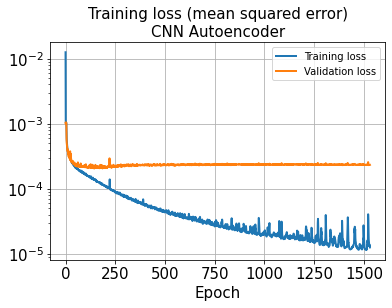

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.plot(hist['val_loss'], lw=2)
plt.title('Training loss (mean squared error)\nCNN Autoencoder', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['Training loss', 'Validation loss'])
plt.grid()
saveName = case_storage + "\\TrainingLoss_val" + str(val_rate) + "test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

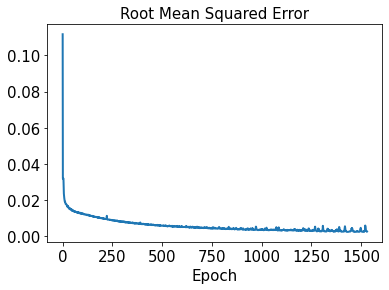

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

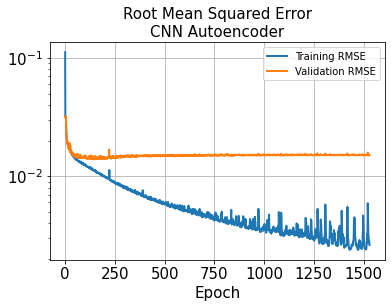

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error\nCNN Autoencoder', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['Training RMSE', 'Validation RMSE'])
plt.grid()
saveName = case_storage + "\\RMSE_val" + str(val_rate) + "test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
test_results = model.evaluate(x_test)

7/7 [==============================] - 0s 4ms/step - loss: 5.9906e-06 - rmse: 0.0000e+00


In [44]:
decoded_train_nor = model.predict(x_train)
decoded_val_nor = model.predict(x_val)
decoded_test_nor = model.predict(x_test)

7/7 [==============================] - 0s 26ms/step


In [45]:
decoded_train = decoded_train_nor*(targetMax-targetMin) + targetMin
decoded_val = decoded_val_nor*(targetMax-targetMin) + targetMin
decoded_test = decoded_test_nor*(targetMax-targetMin) + targetMin

In [46]:
os.chdir("D:\\TrainedModels\\20221101")
model_name = "20221101AeroCNN-II_FlowField_nGrid128_val" + str(val_rate) + "test"+str(test_rate)+".h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
error_train_abs = np.abs(decoded_train - y_train)

In [48]:
error_val_abs = np.abs(decoded_val - y_val)

In [49]:
error_test_abs = np.abs(decoded_test - y_test)

In [50]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.005769521502892059


In [51]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.036914043450246826


In [52]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.041232605084102626


In [53]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(aa_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum(y_val[i]**2))
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

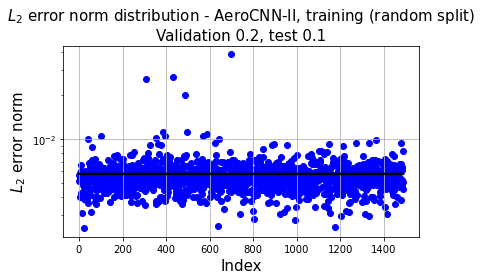

In [56]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training (random split)\nValidation {0}, test {1}'.format(val_rate, test_rate), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

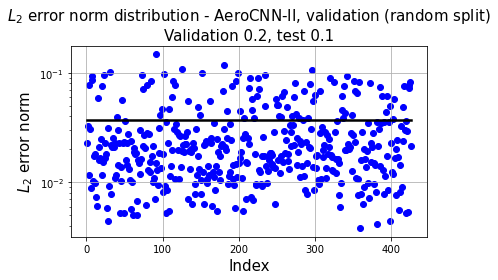

In [57]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_val*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, validation (random split)\nValidation {0}, test {1}'.format(val_rate, test_rate), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

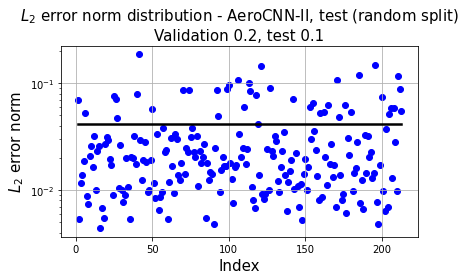

In [58]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test (random split)\nValidation {0}, test {1}'.format(val_rate, test_rate), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [59]:
targetMax

12.3285928196668

In [60]:
targetMin

0.0

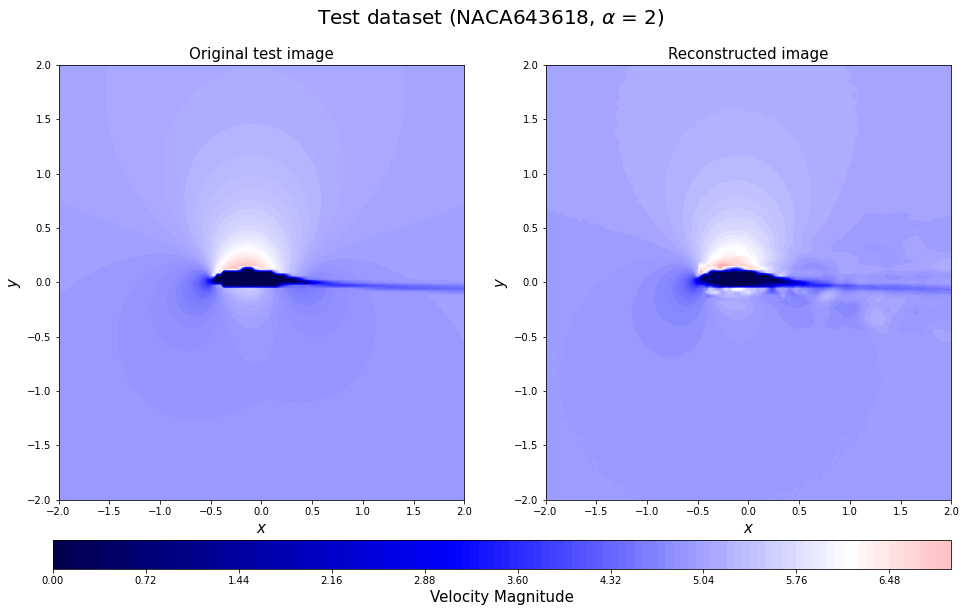

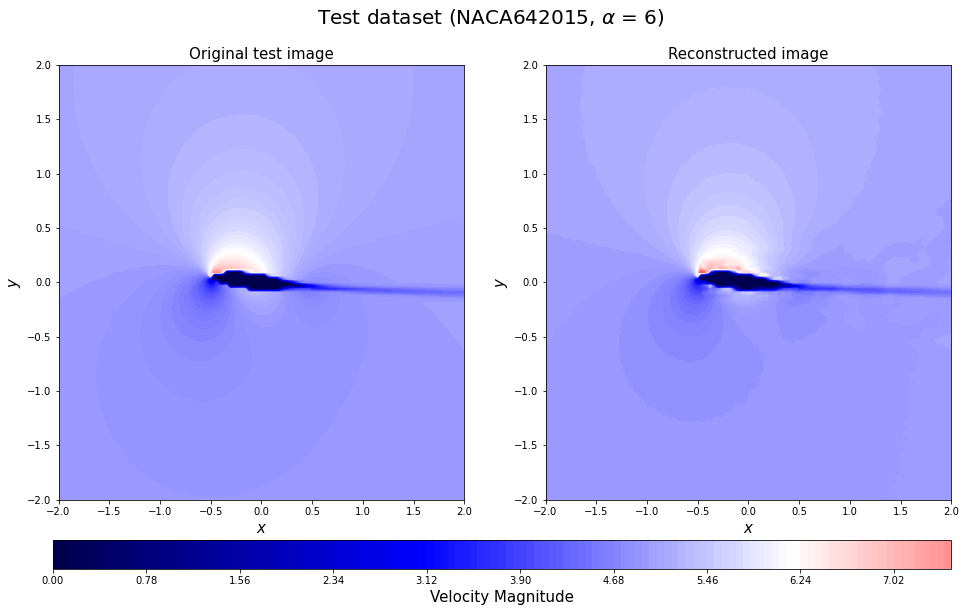

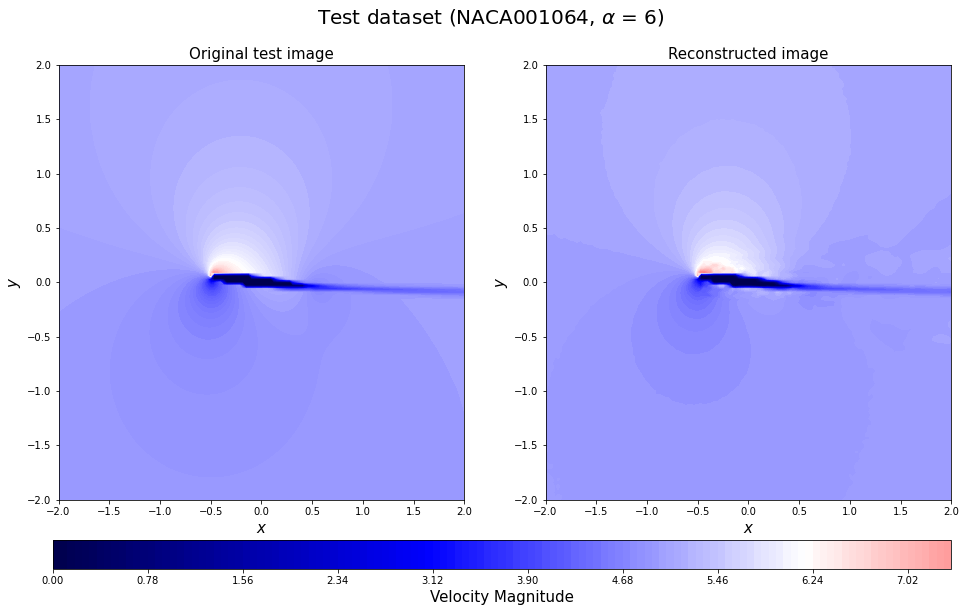

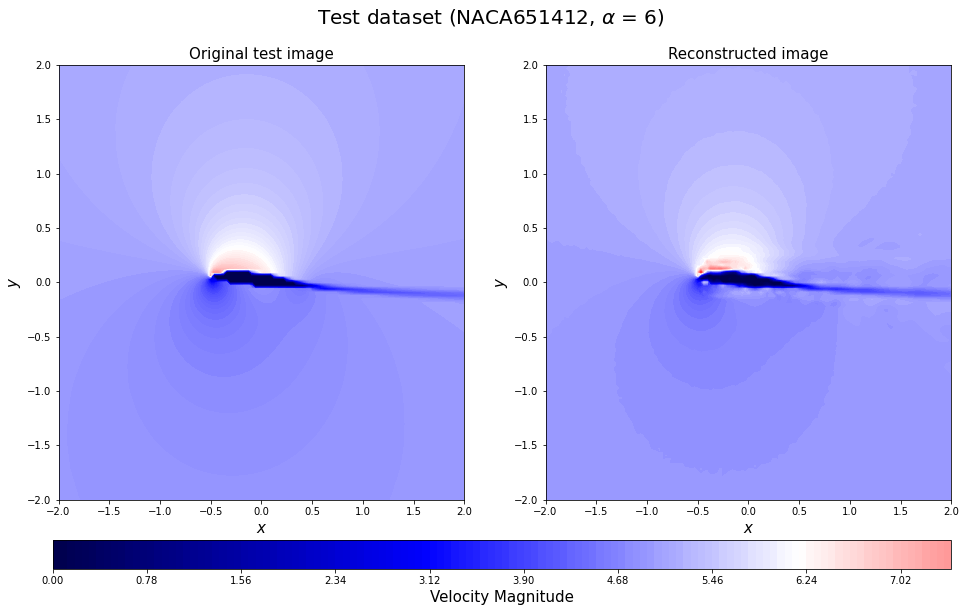

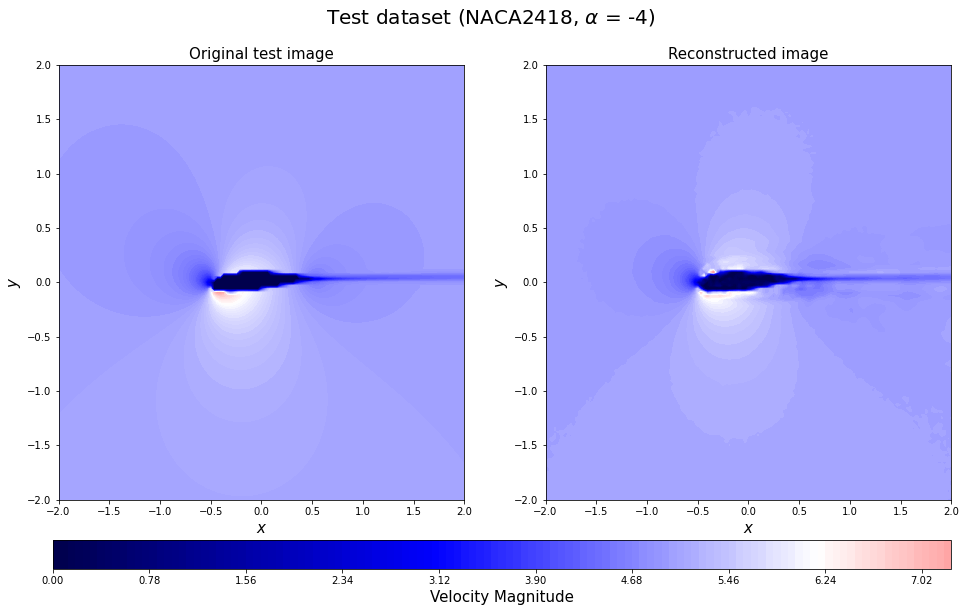

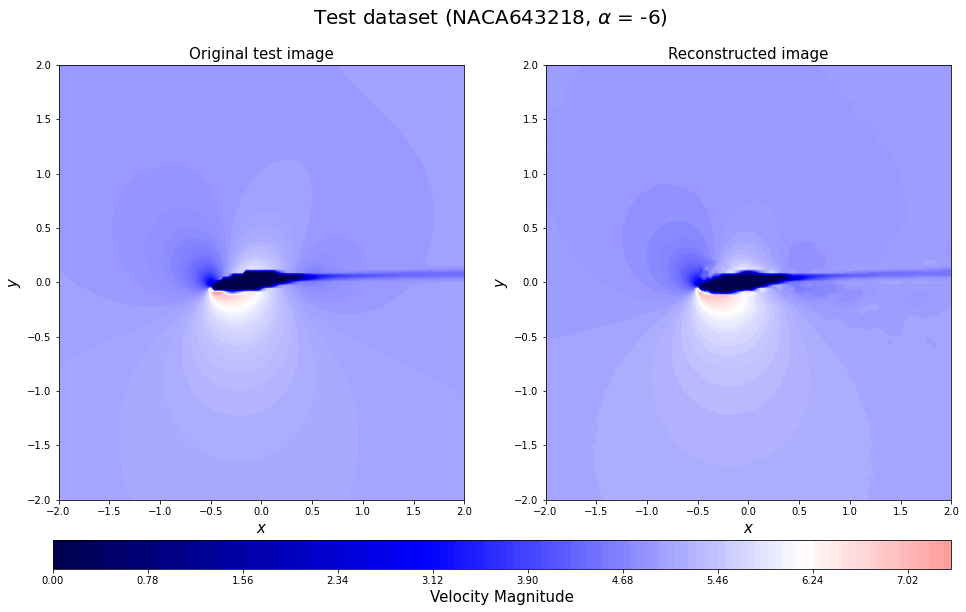

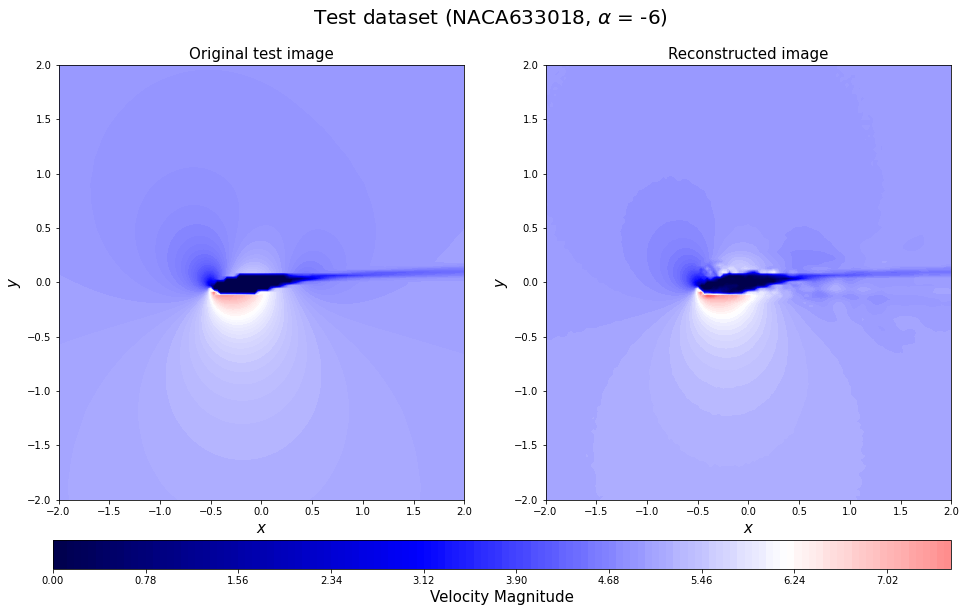

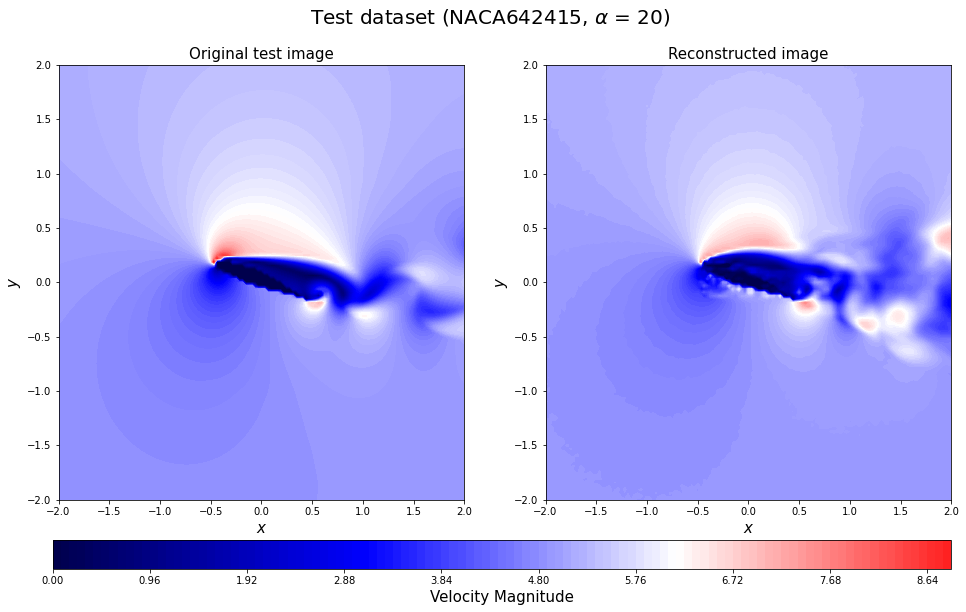

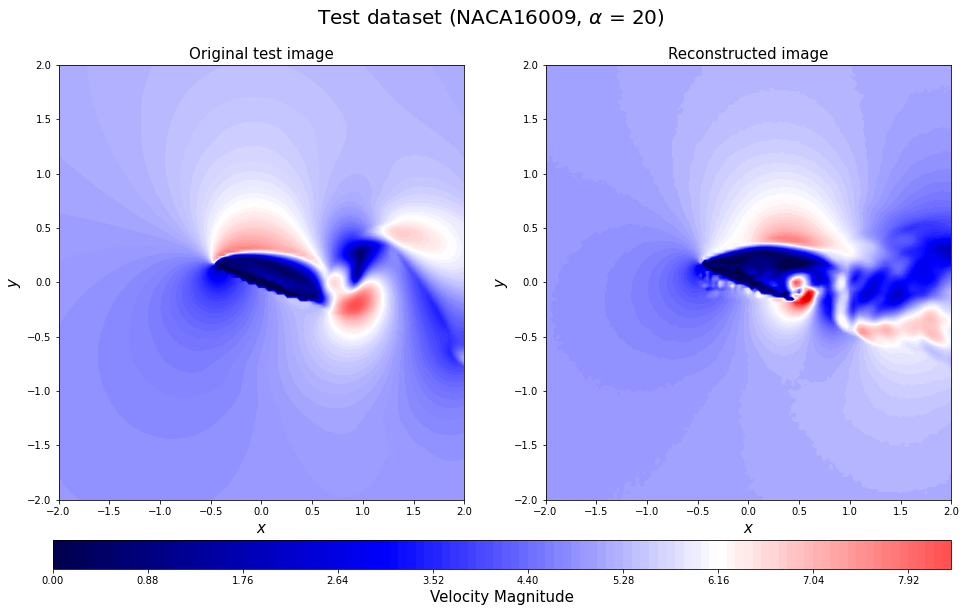

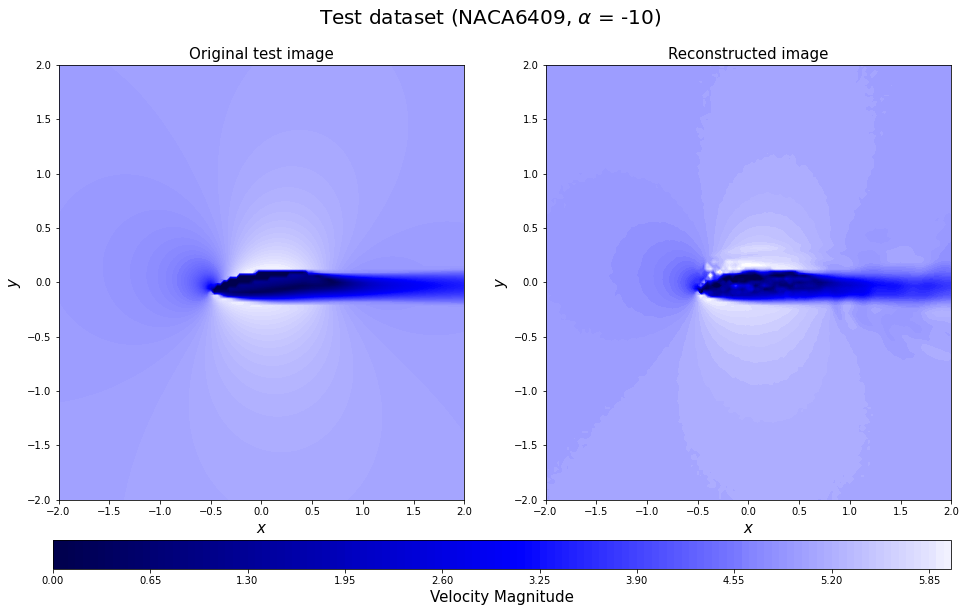

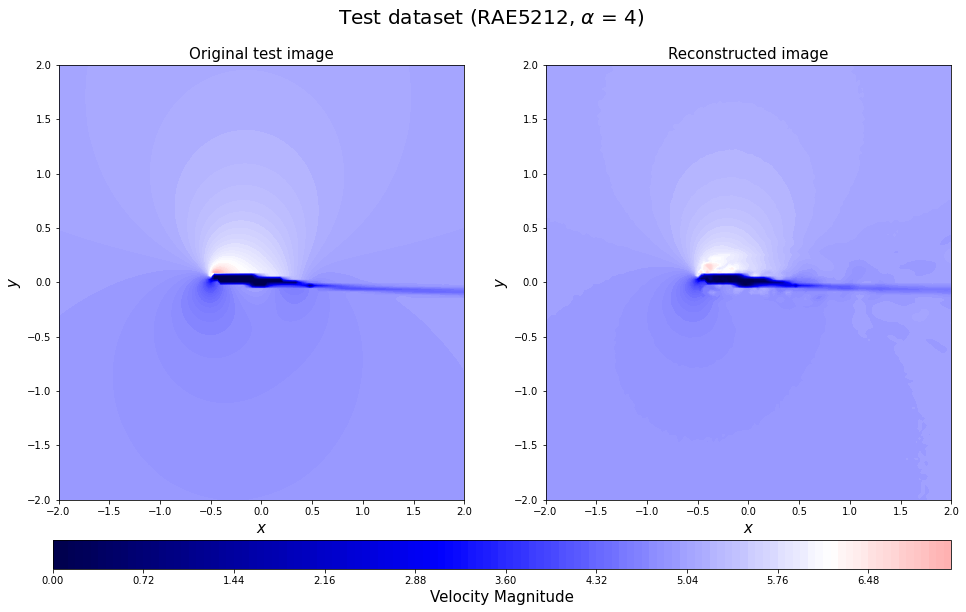

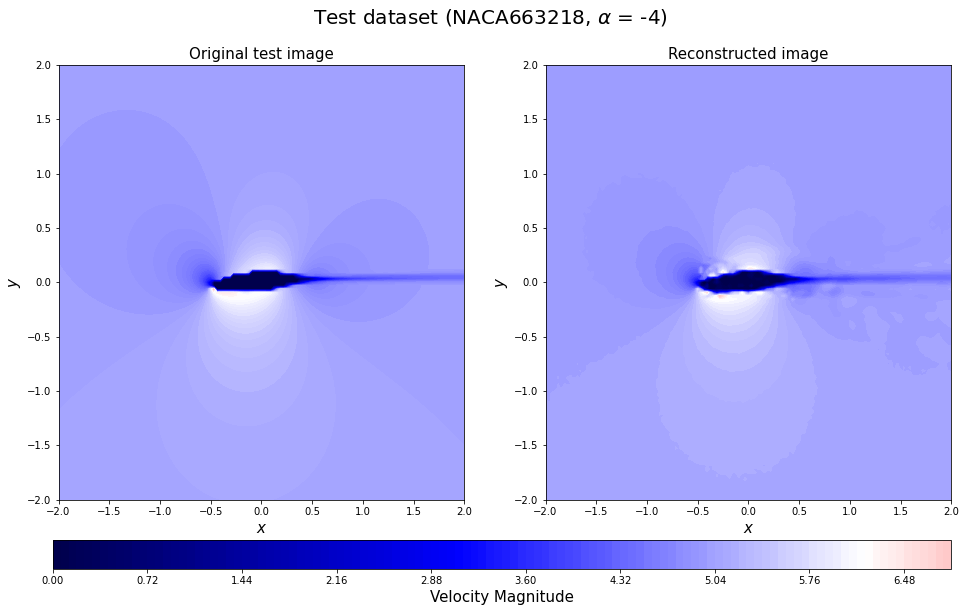

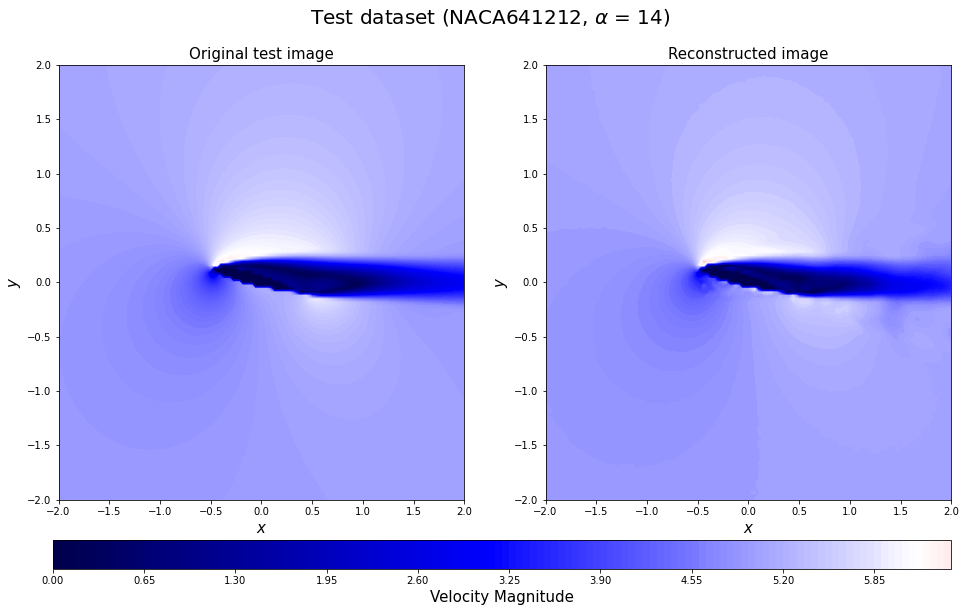

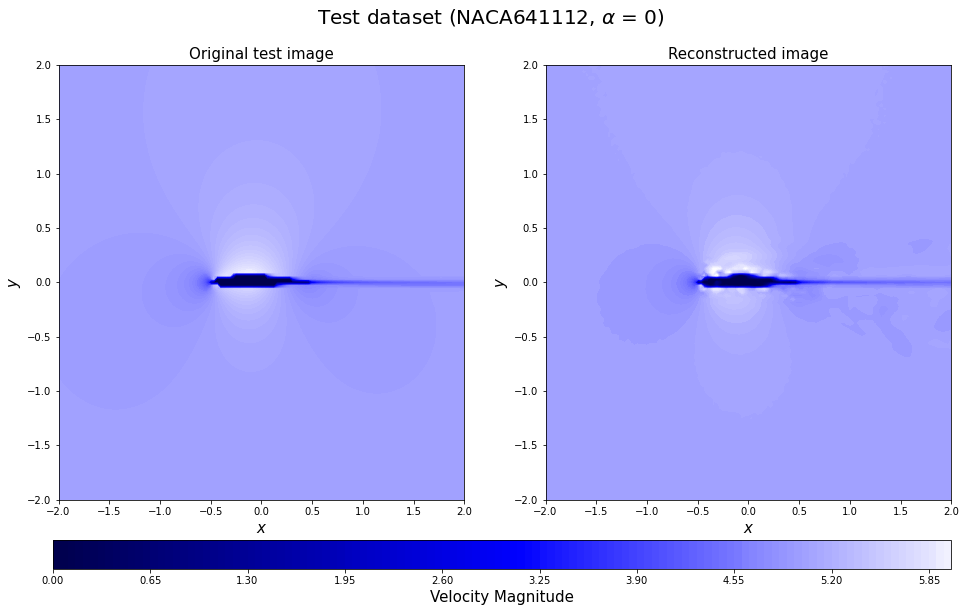

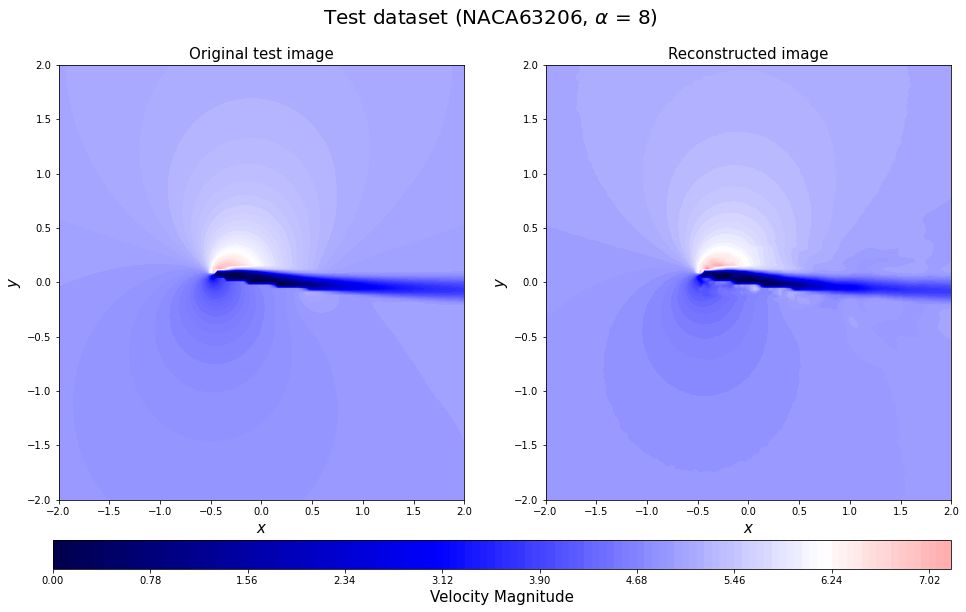

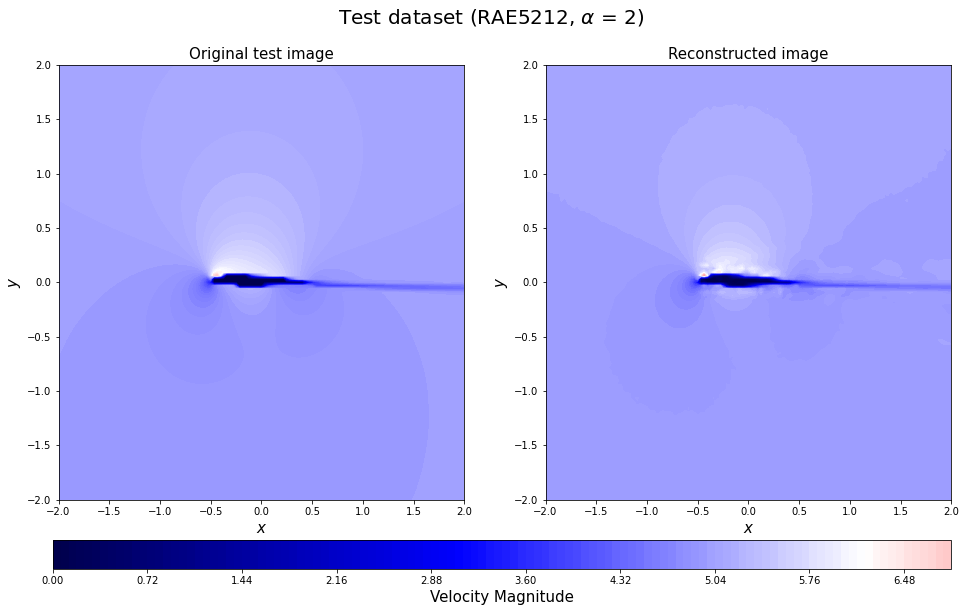

In [61]:
n_grid =129
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_test2_rotate = y_test[2*16+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[2*16+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test2_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[2*16+c])[3:-2], aa_test[2*16+c]),fontsize=20)
    plt.show()

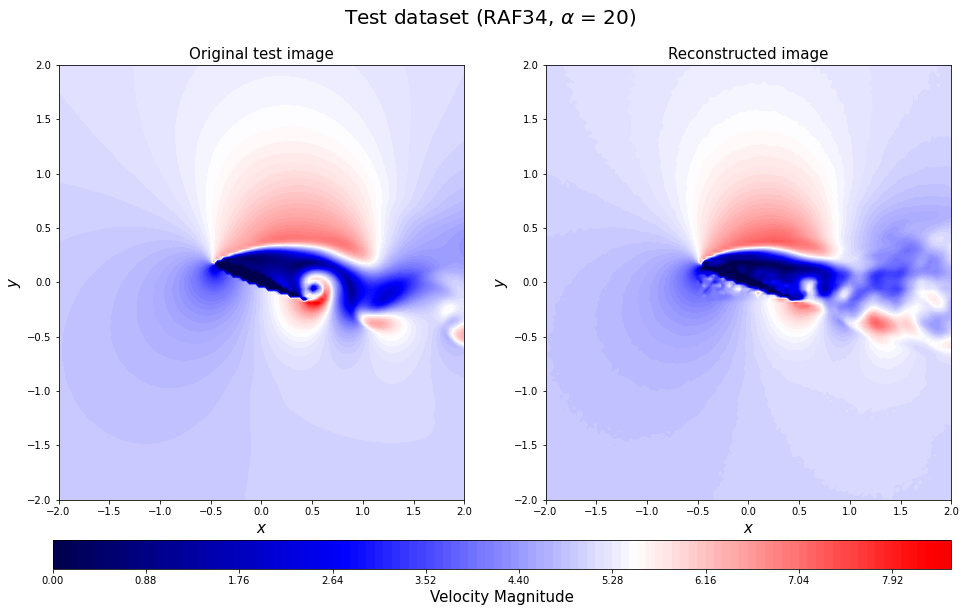

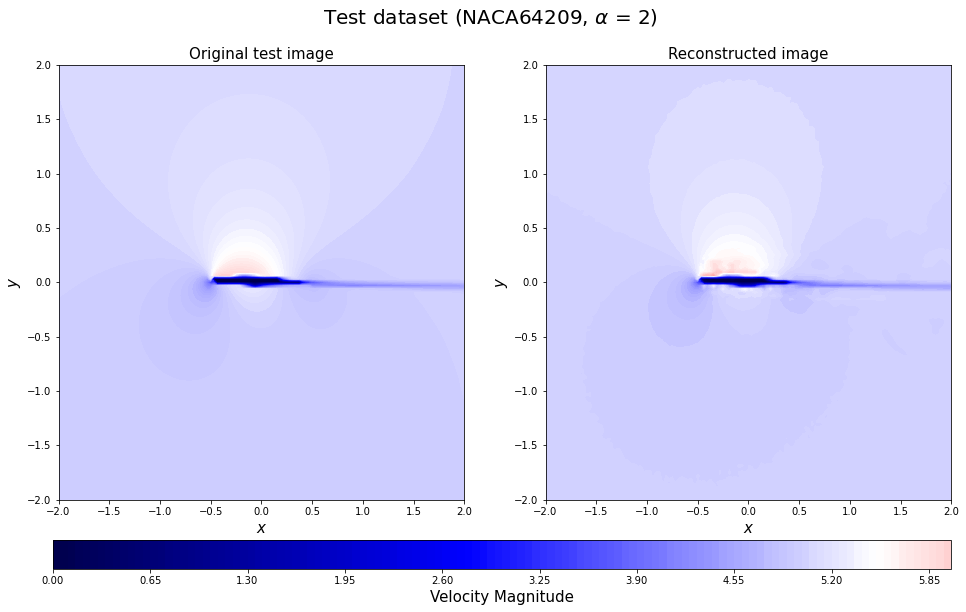

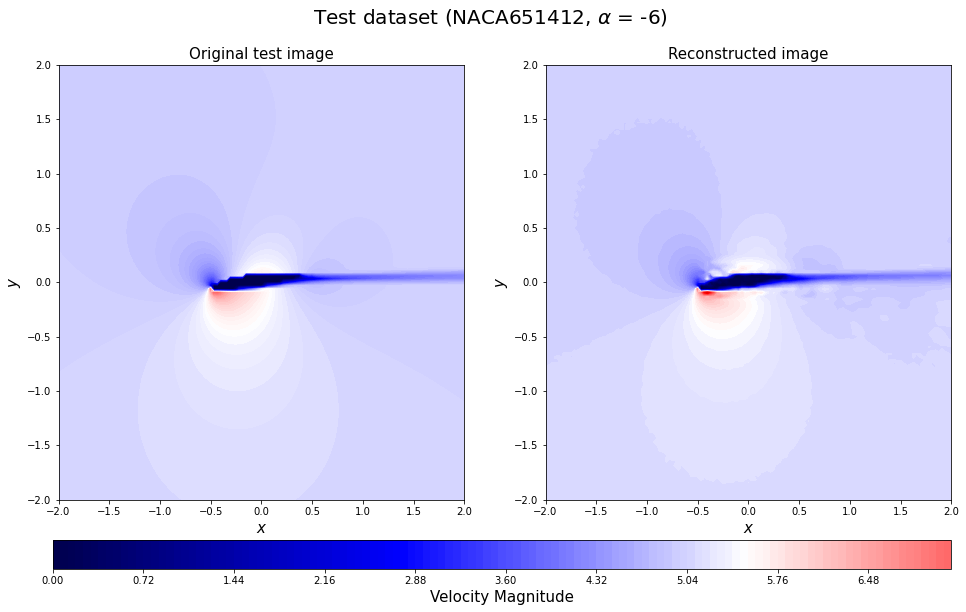

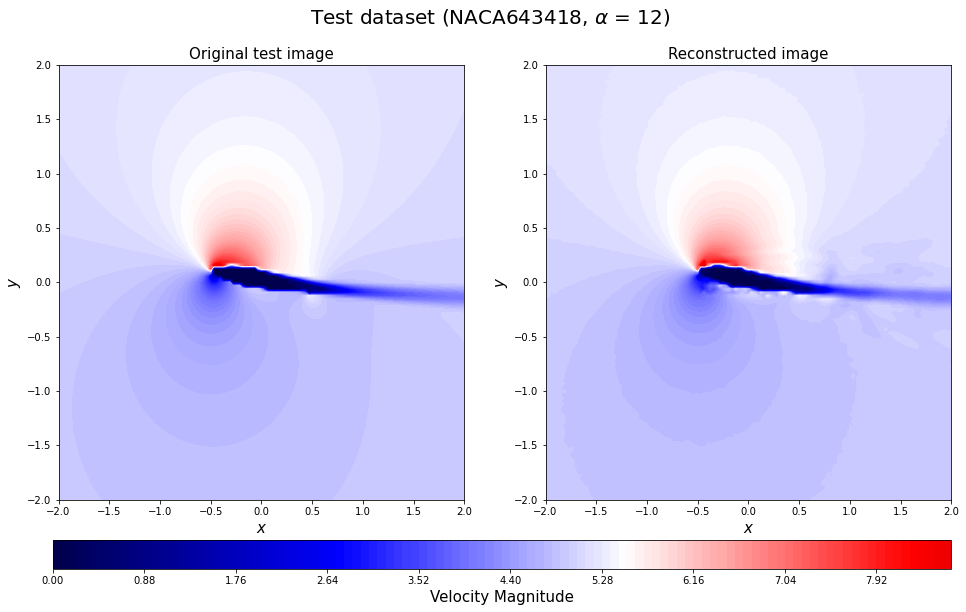

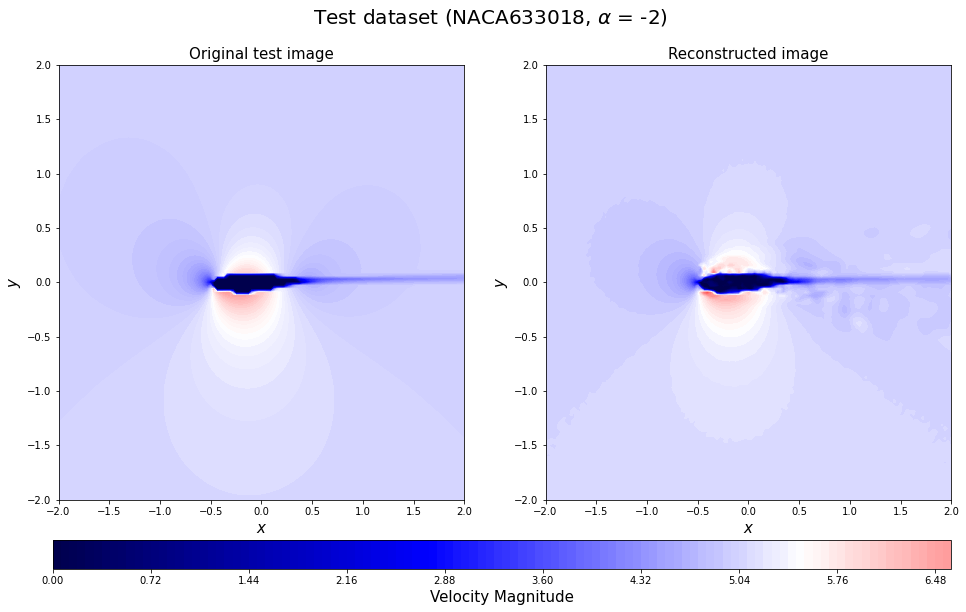

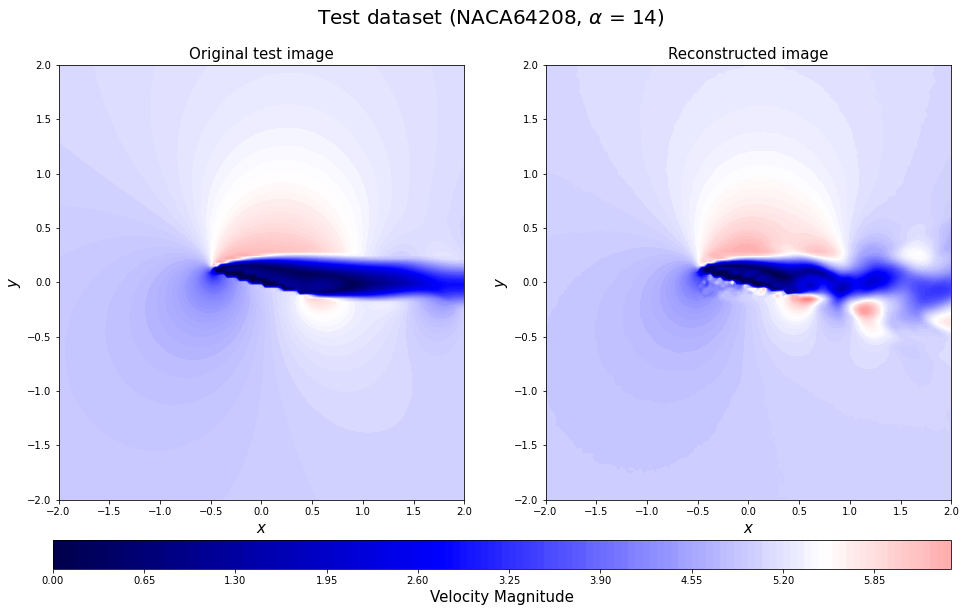

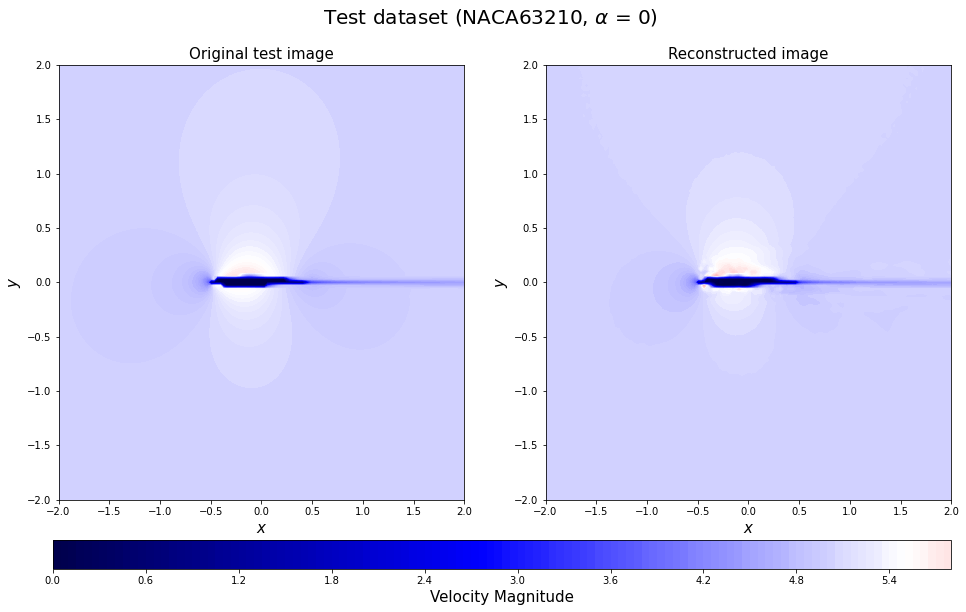

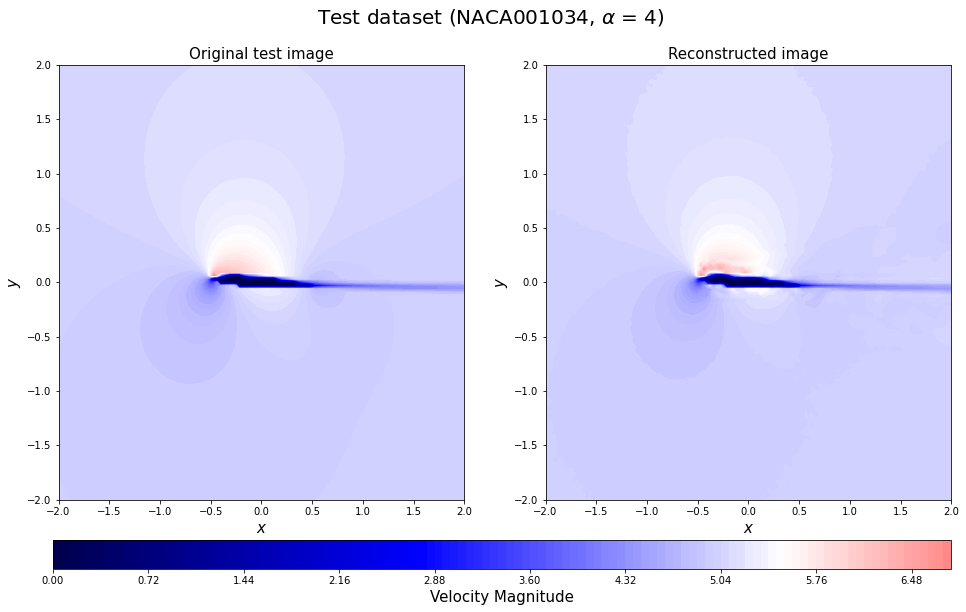

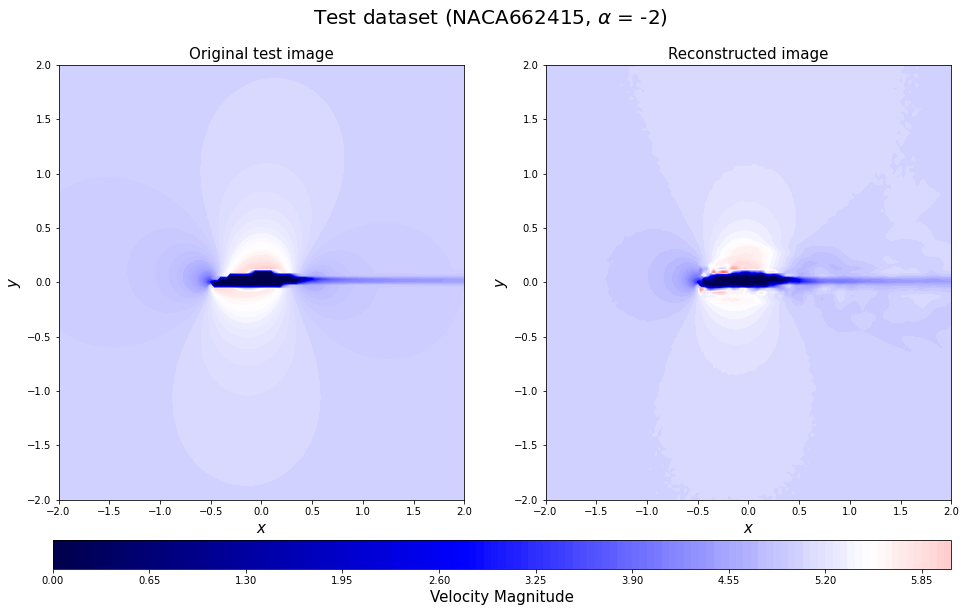

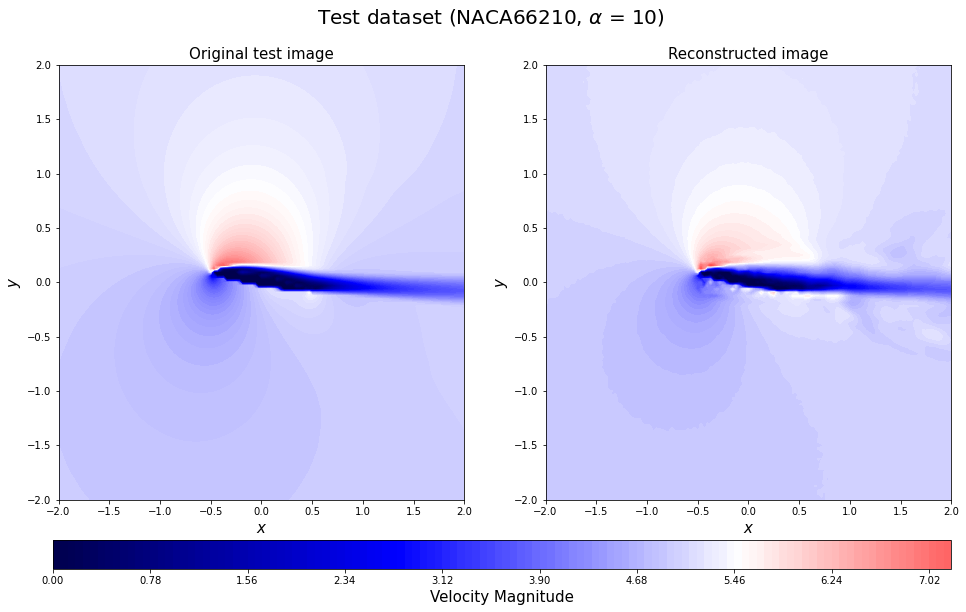

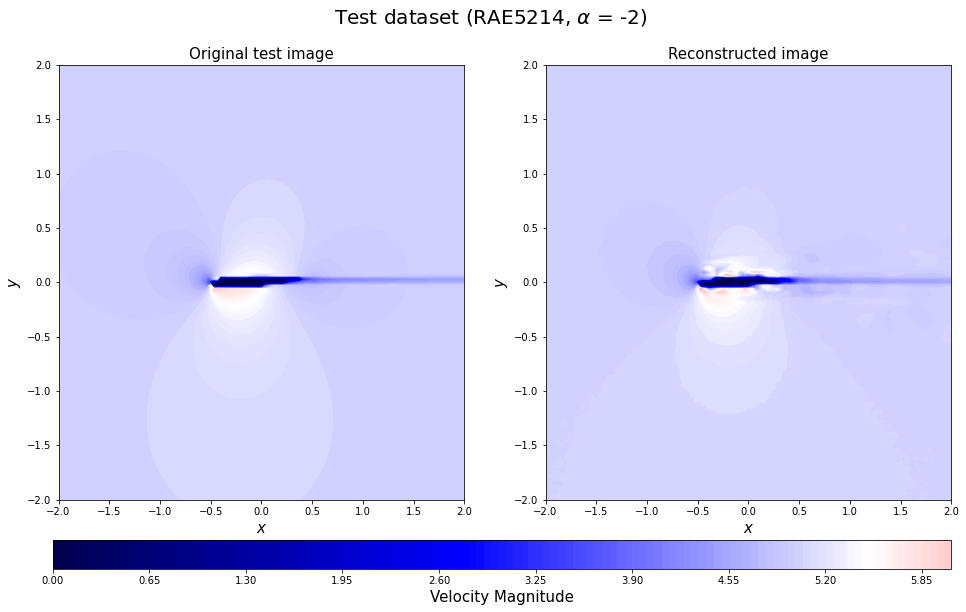

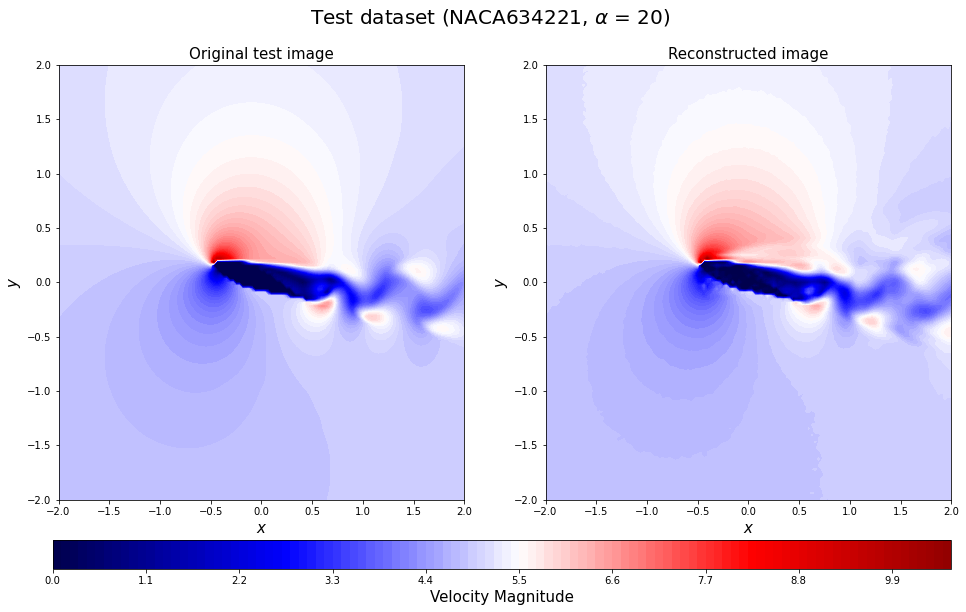

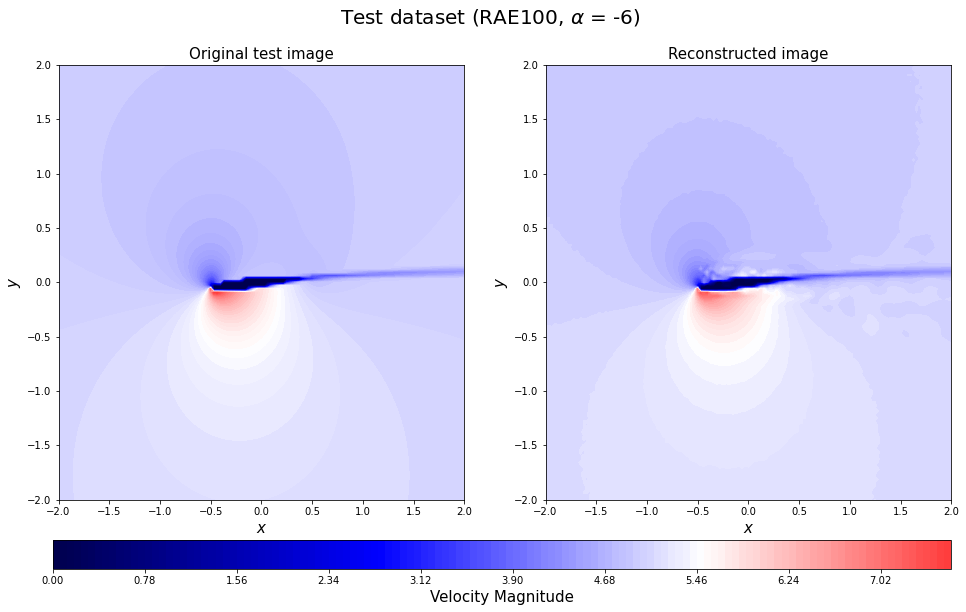

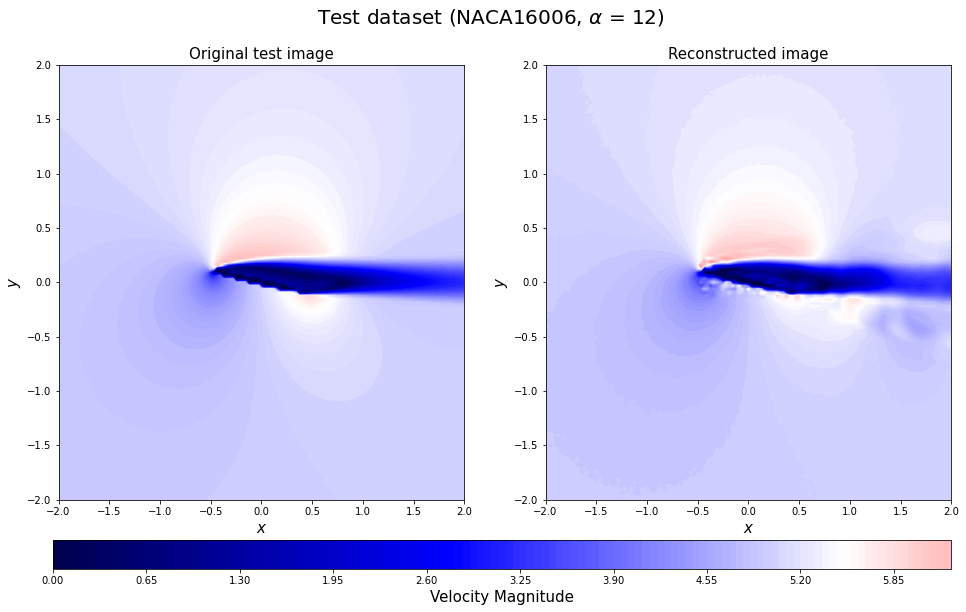

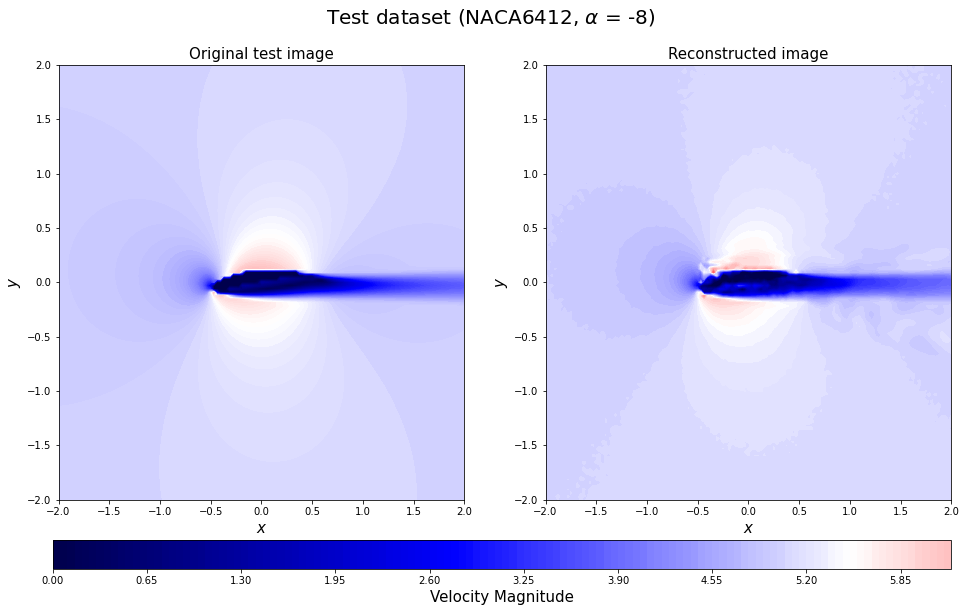

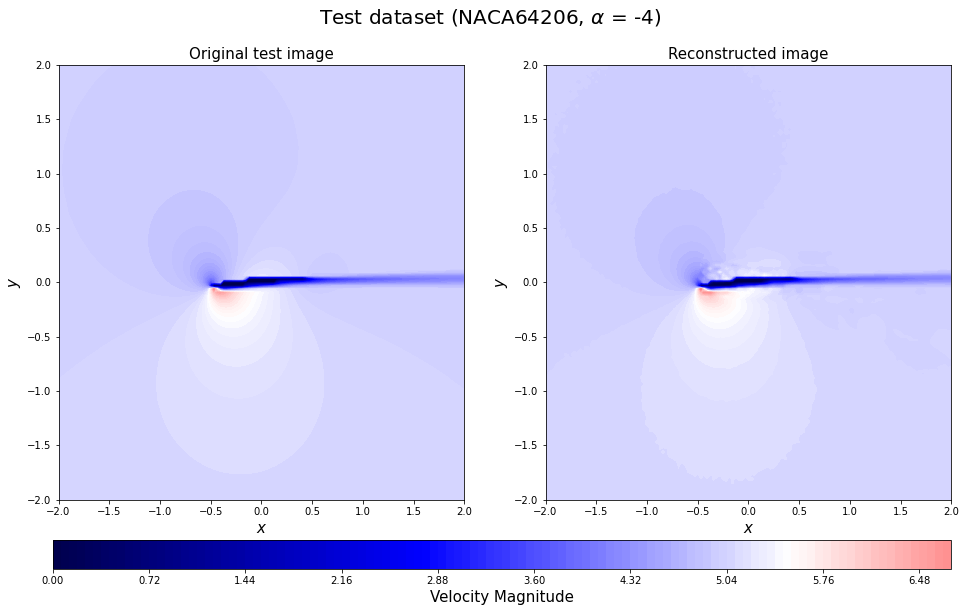

In [62]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_test0_rotate = y_test[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
    plt.show()

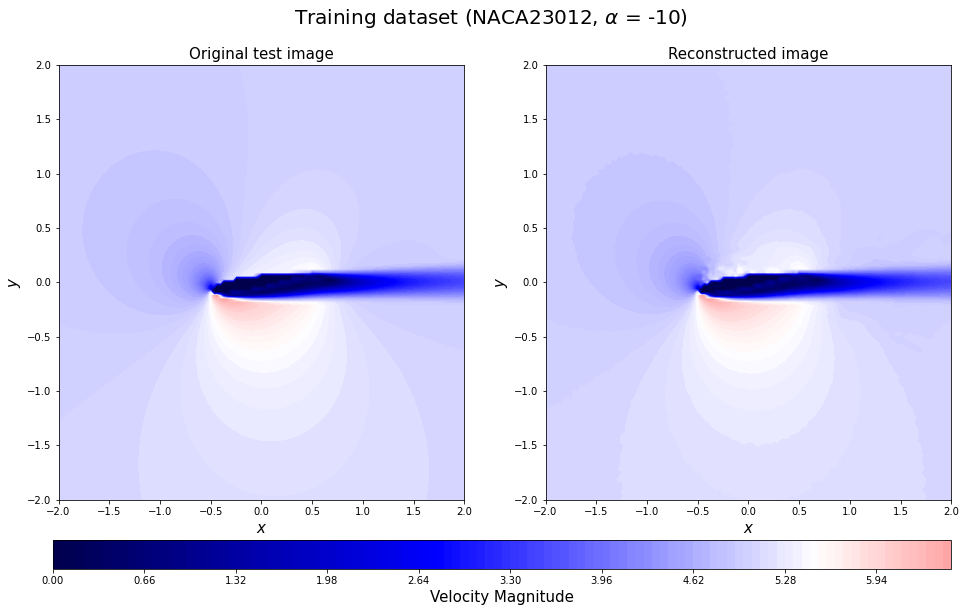

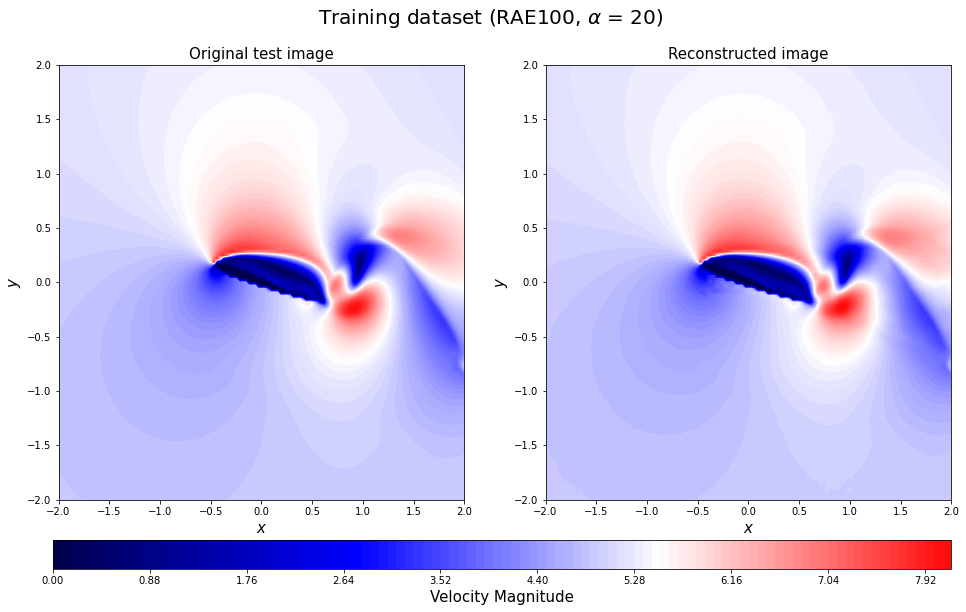

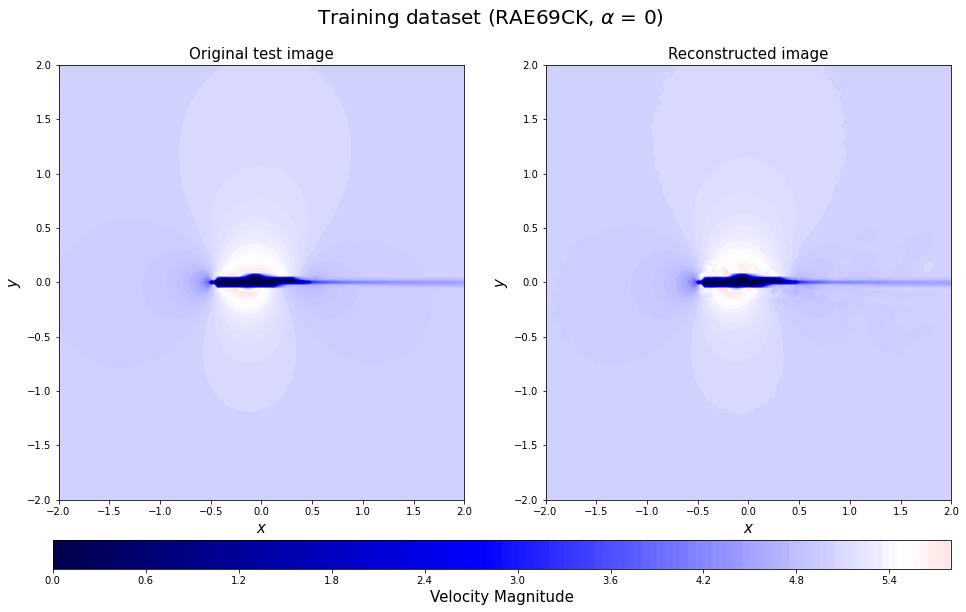

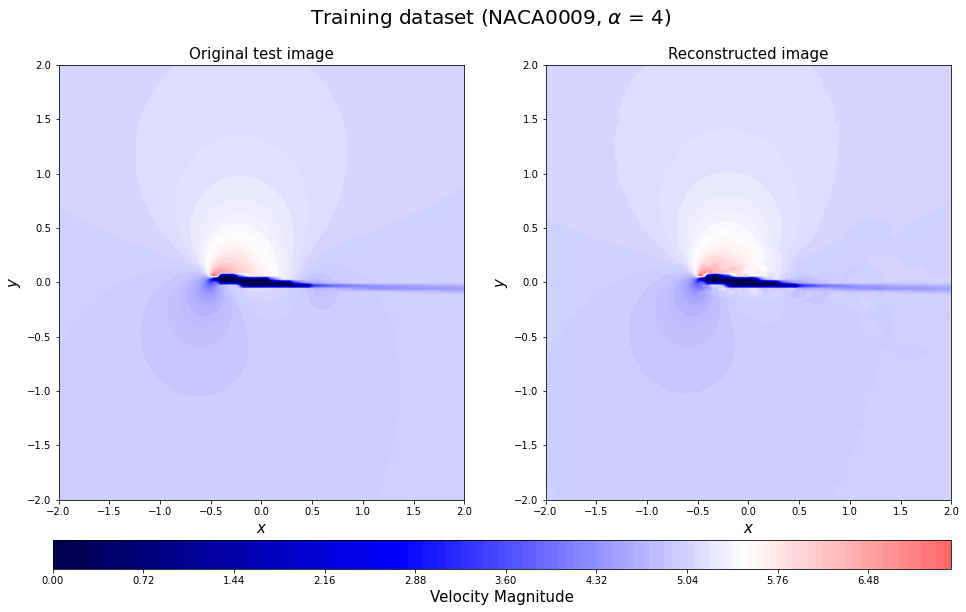

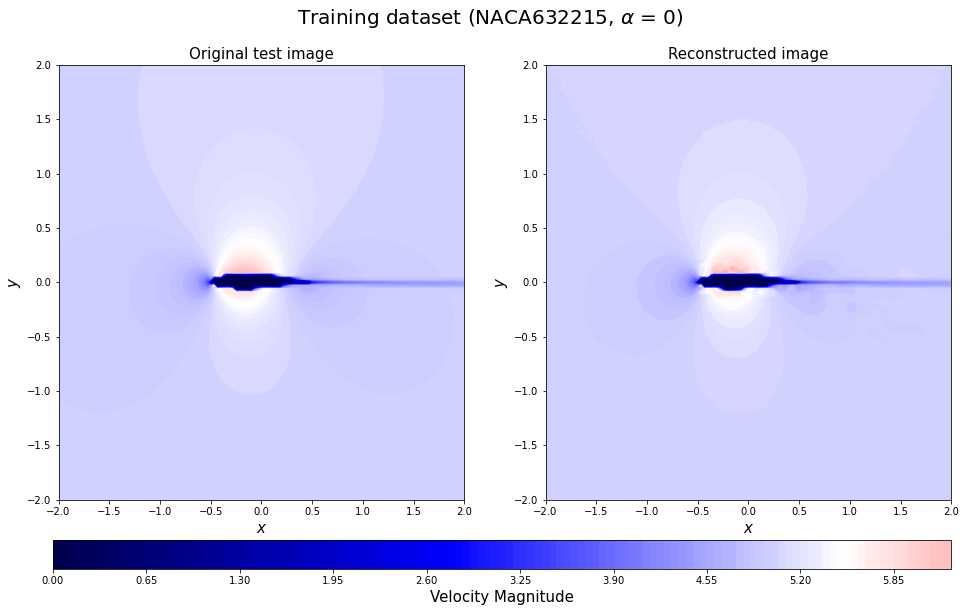

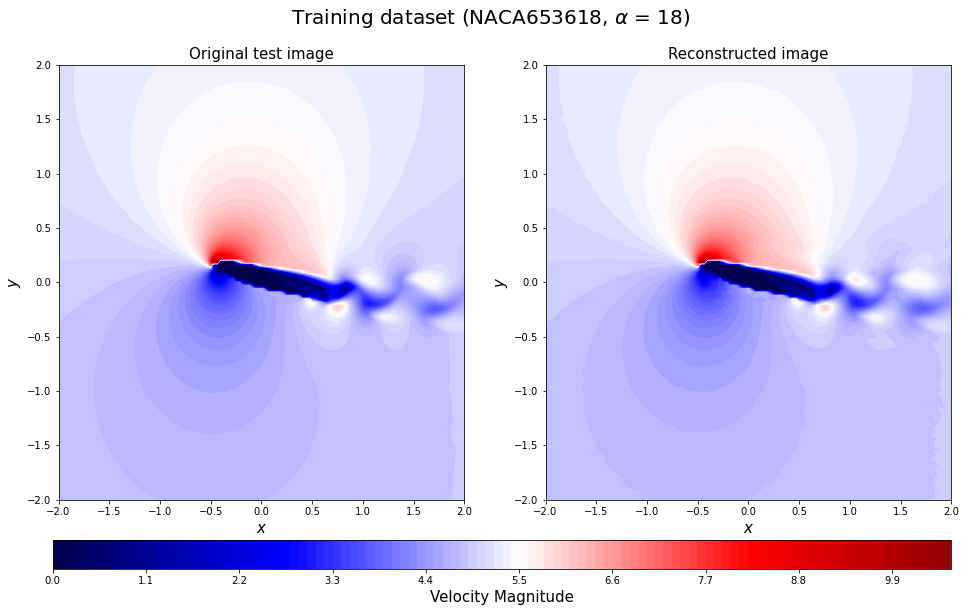

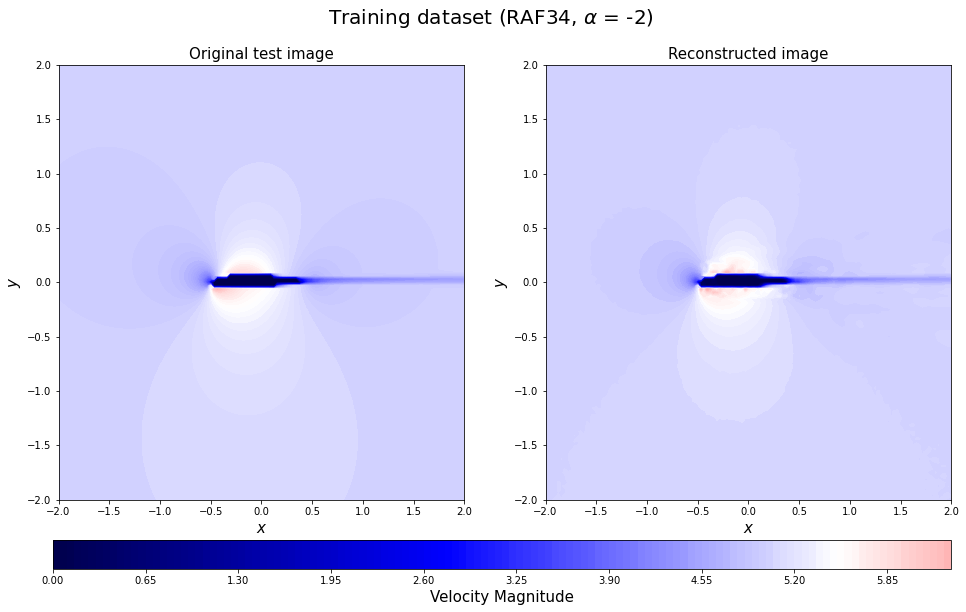

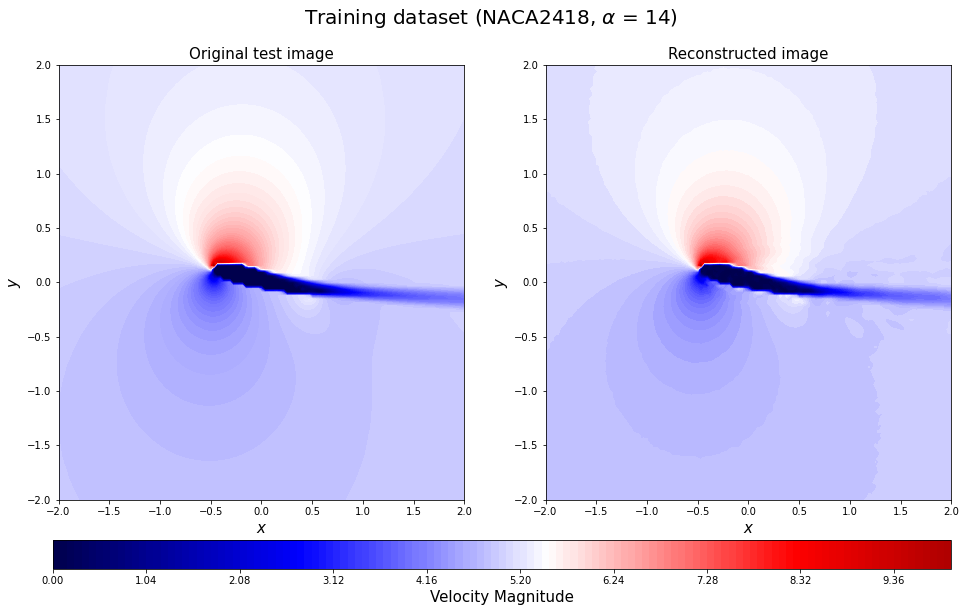

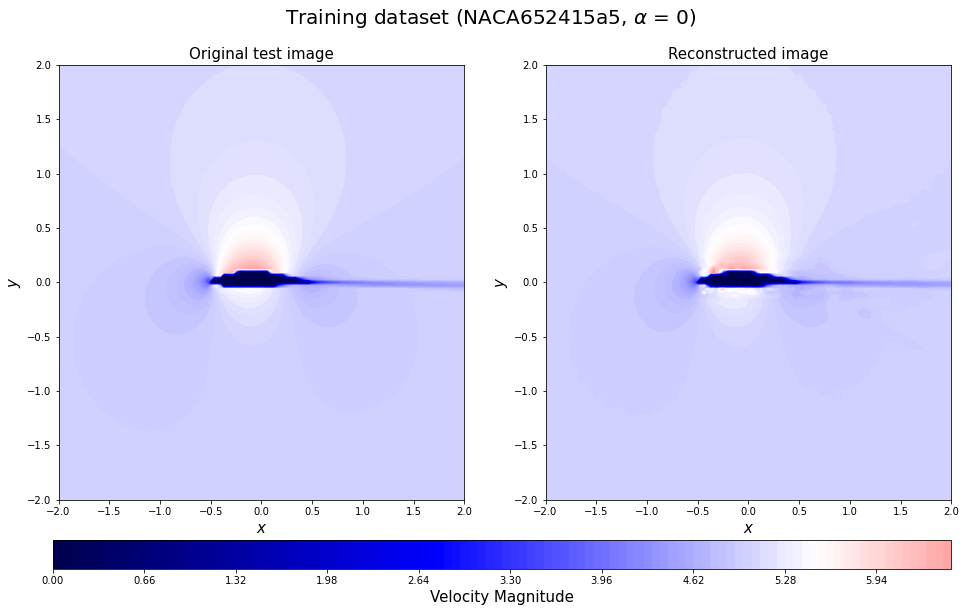

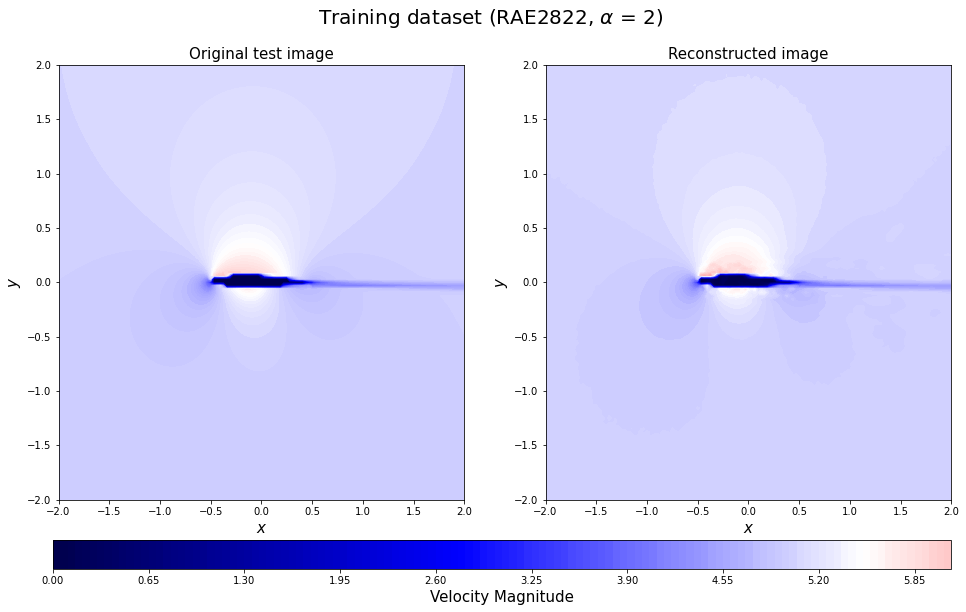

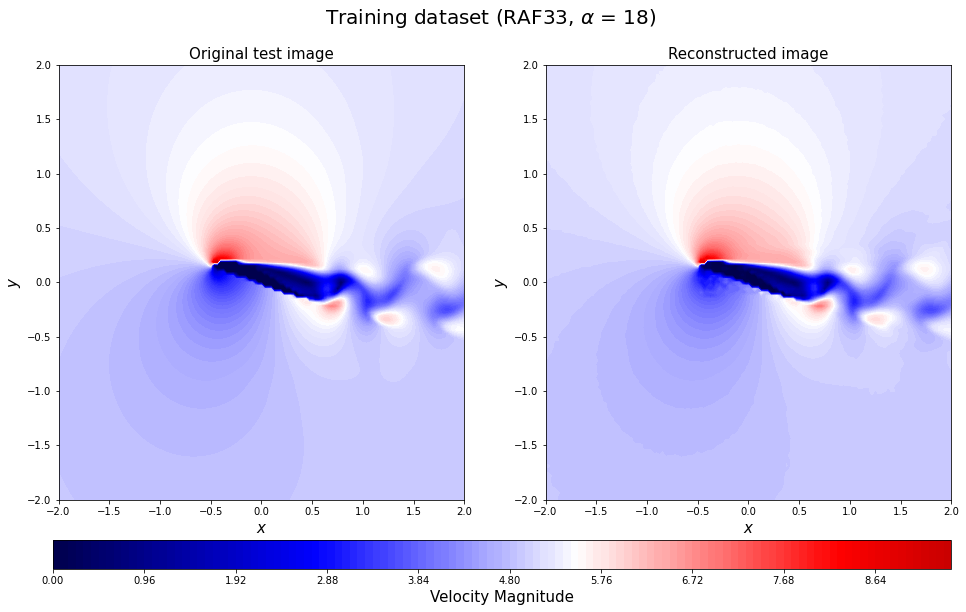

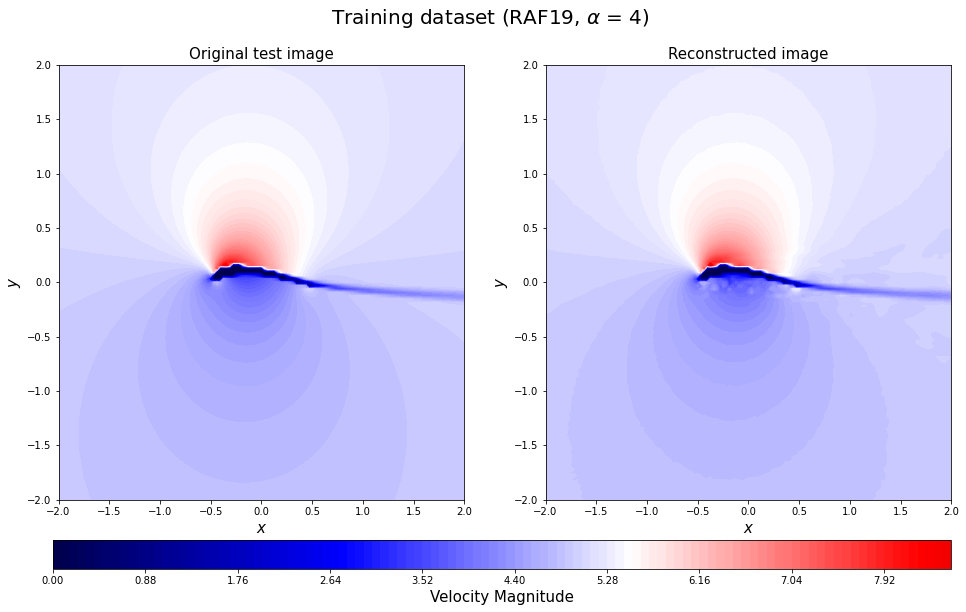

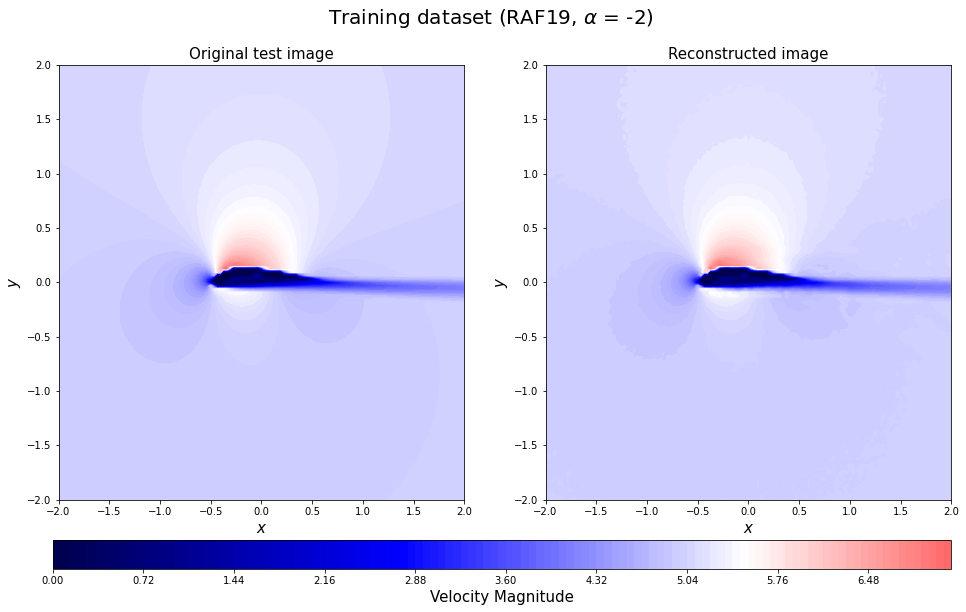

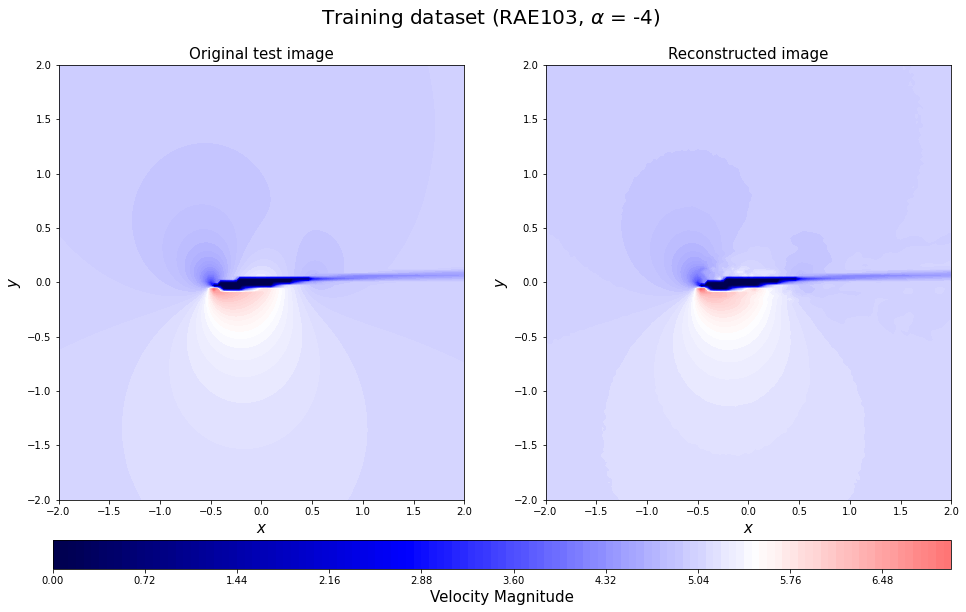

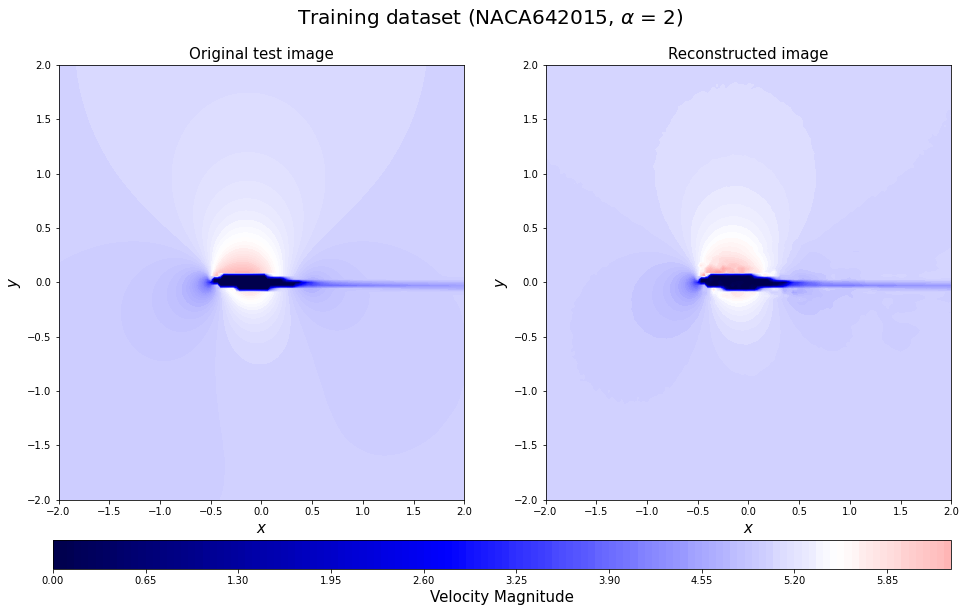

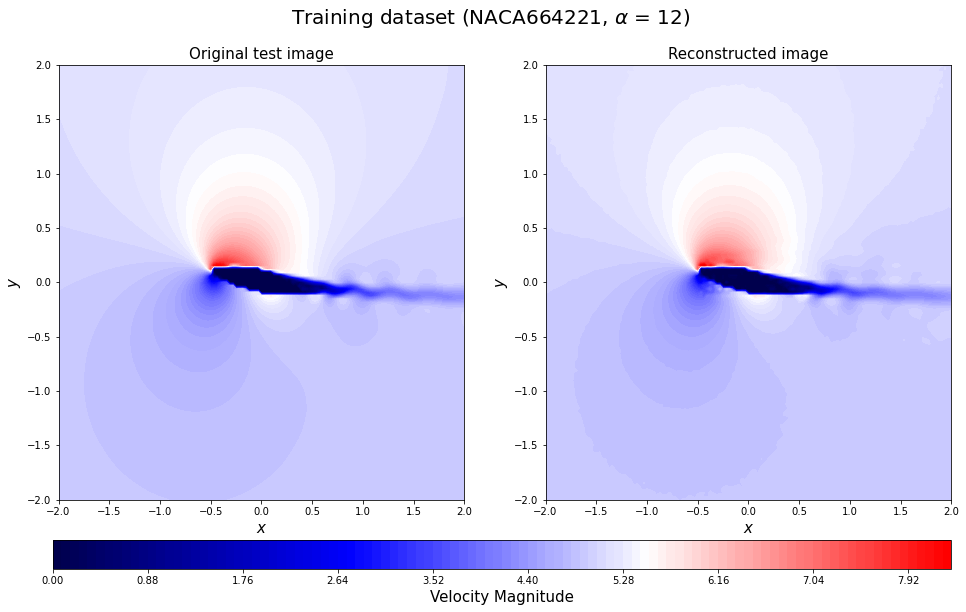

In [63]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_train0_rotate = y_train[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train0_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[c])[3:-2], aa_train[c]),fontsize=20)
    plt.show()

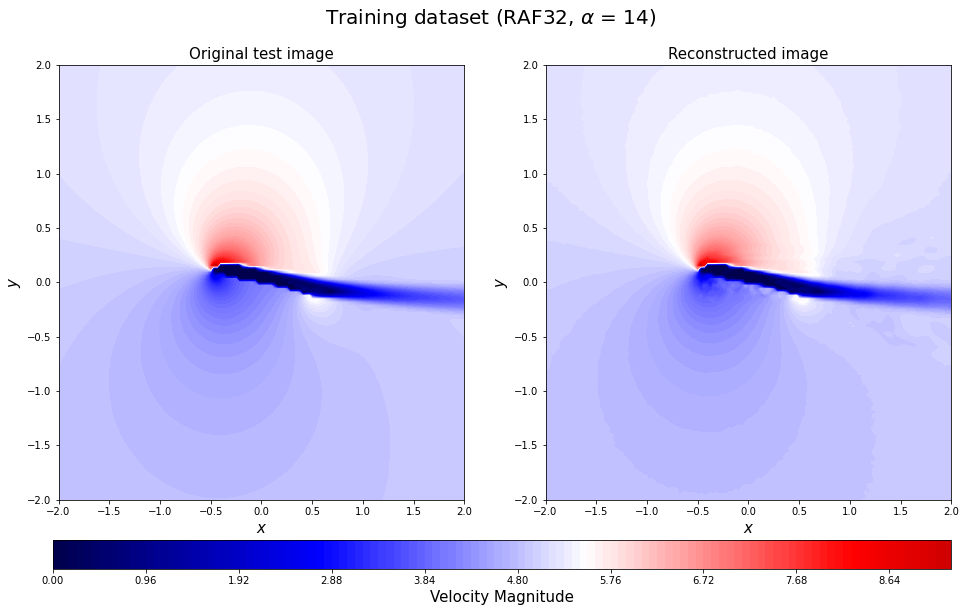

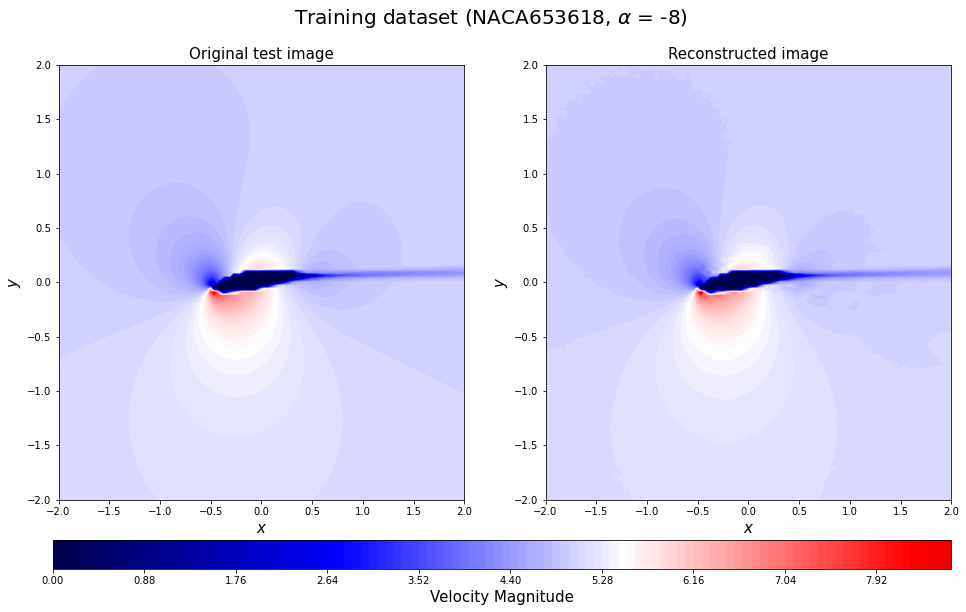

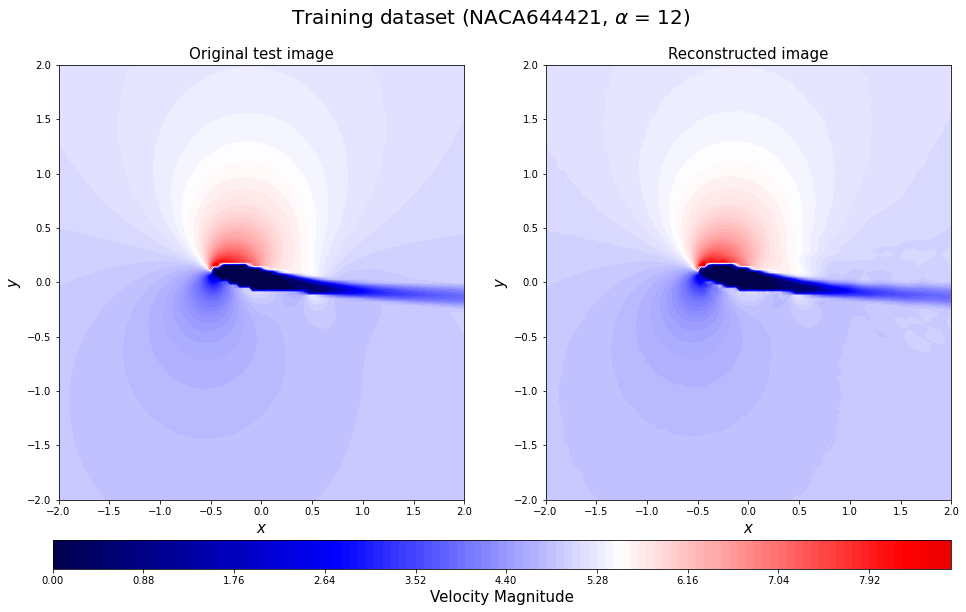

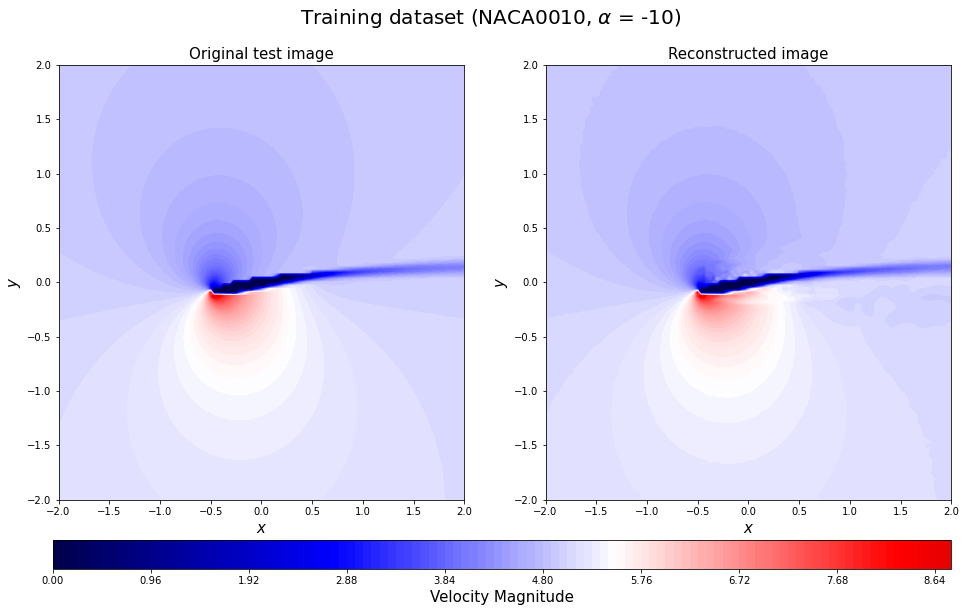

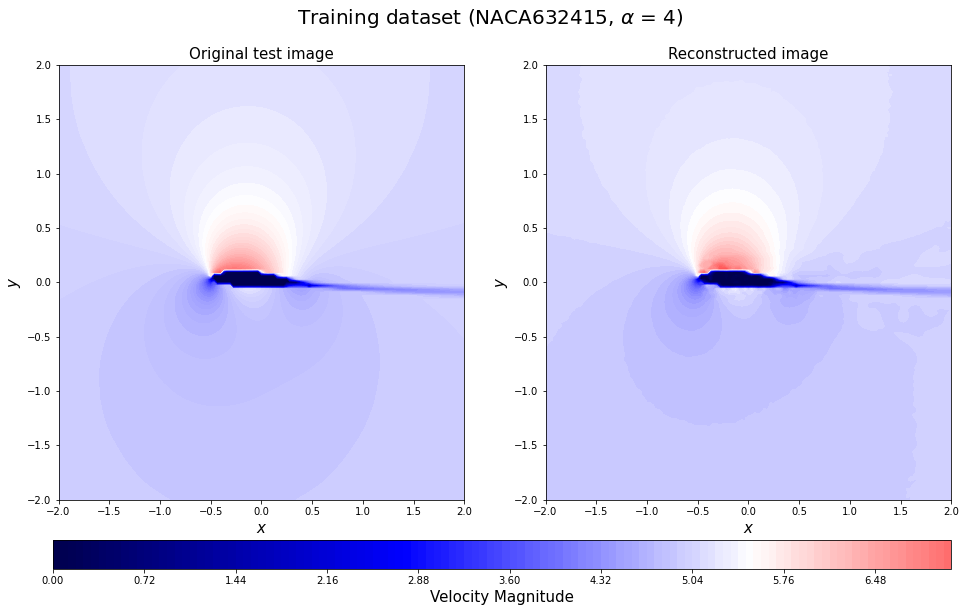

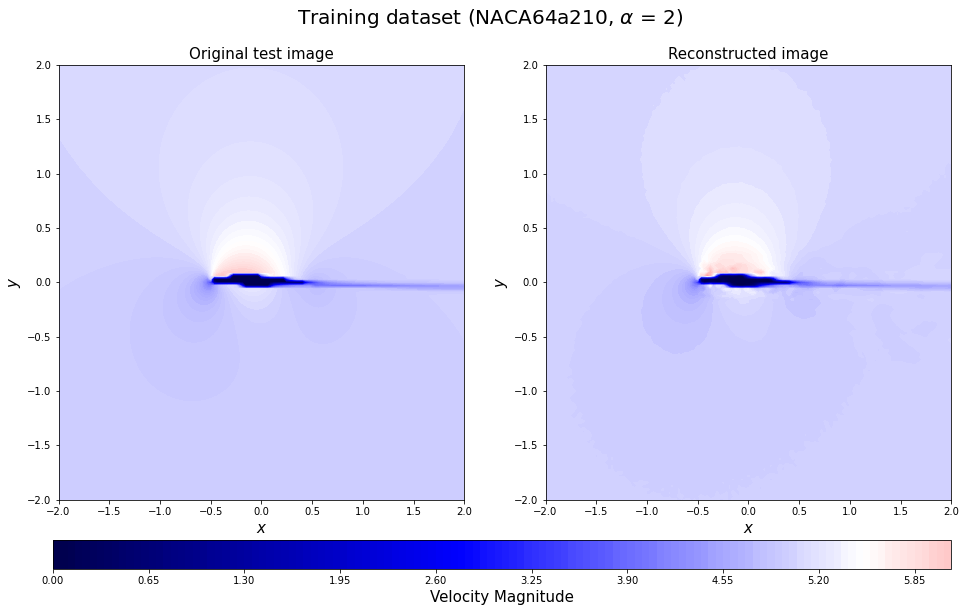

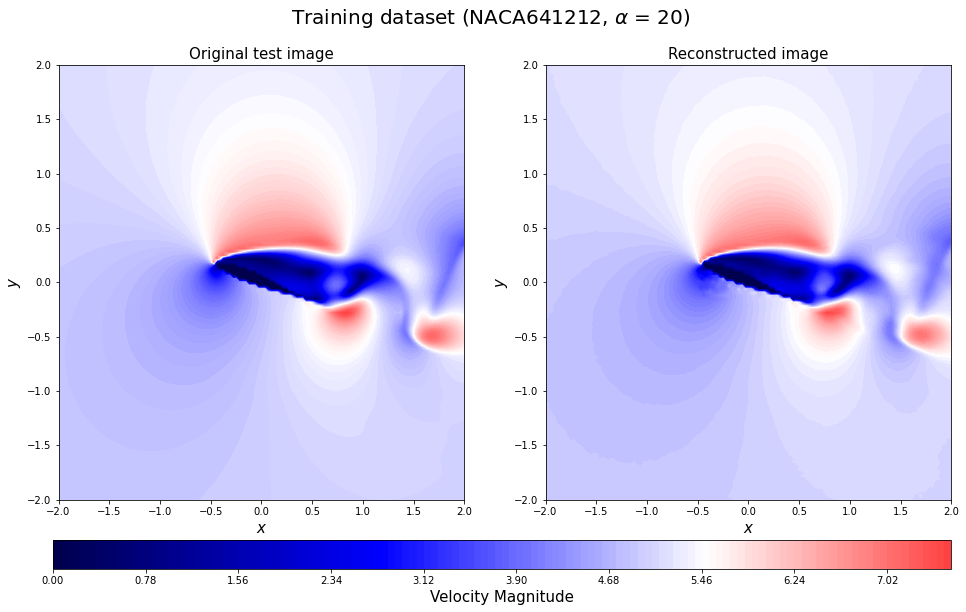

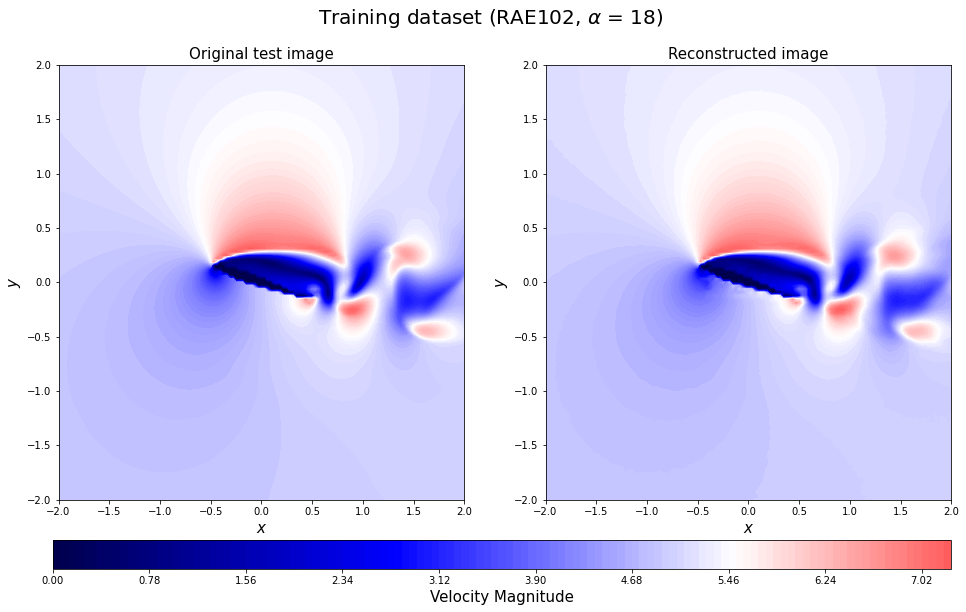

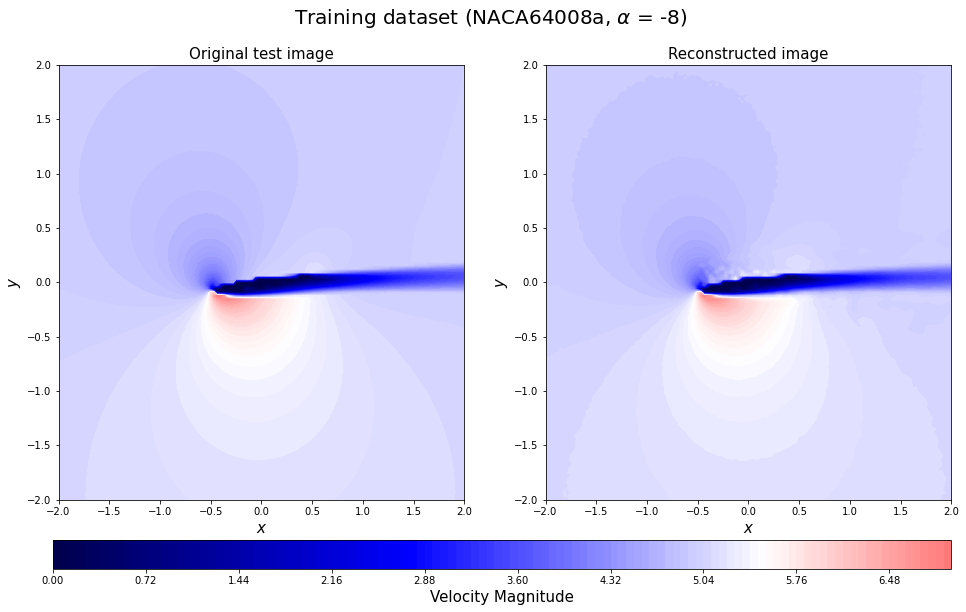

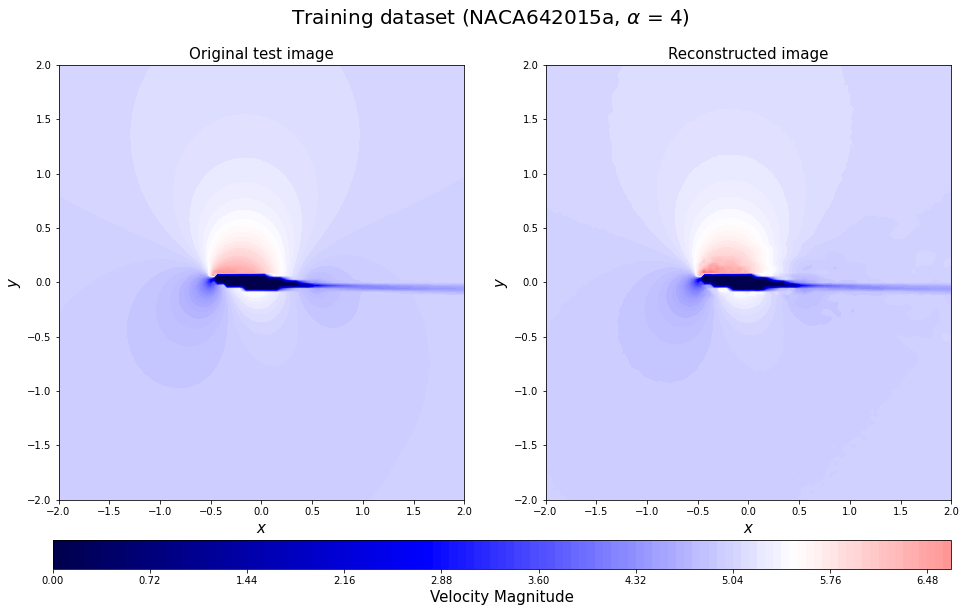

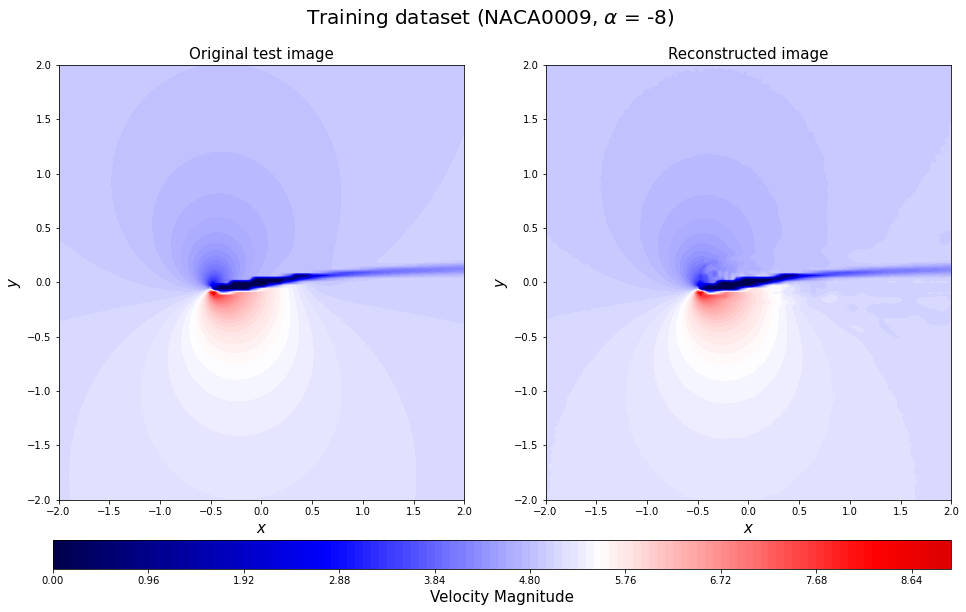

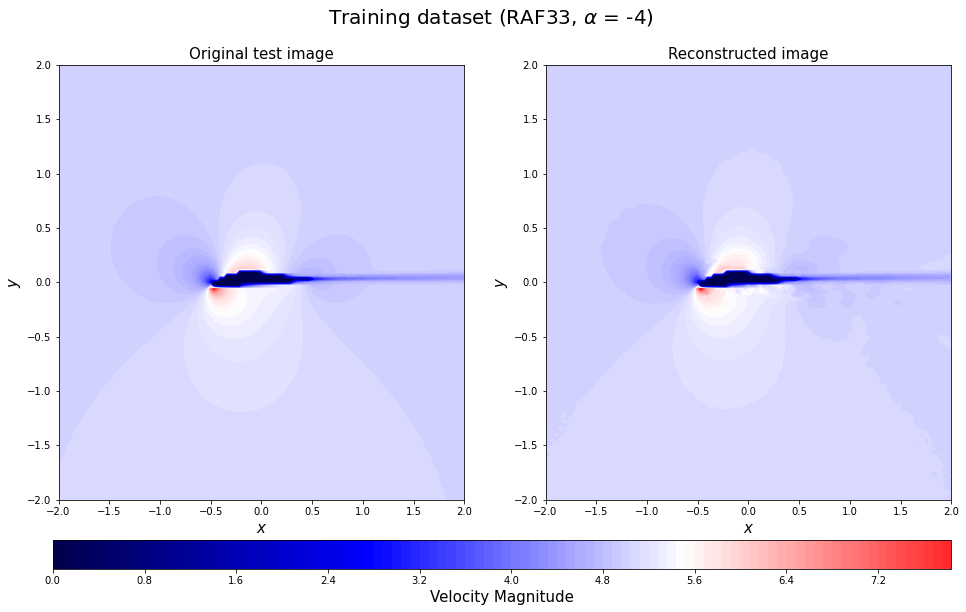

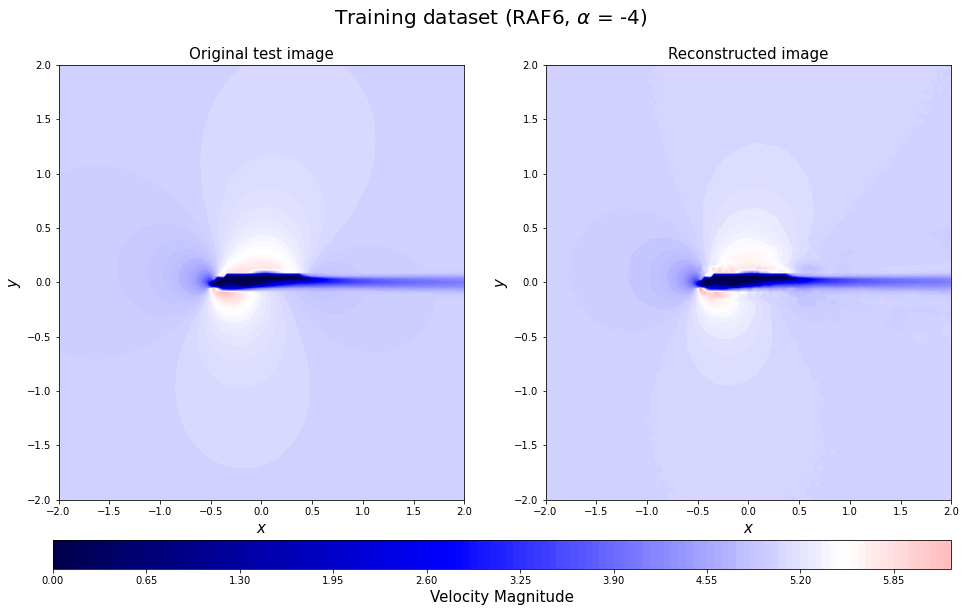

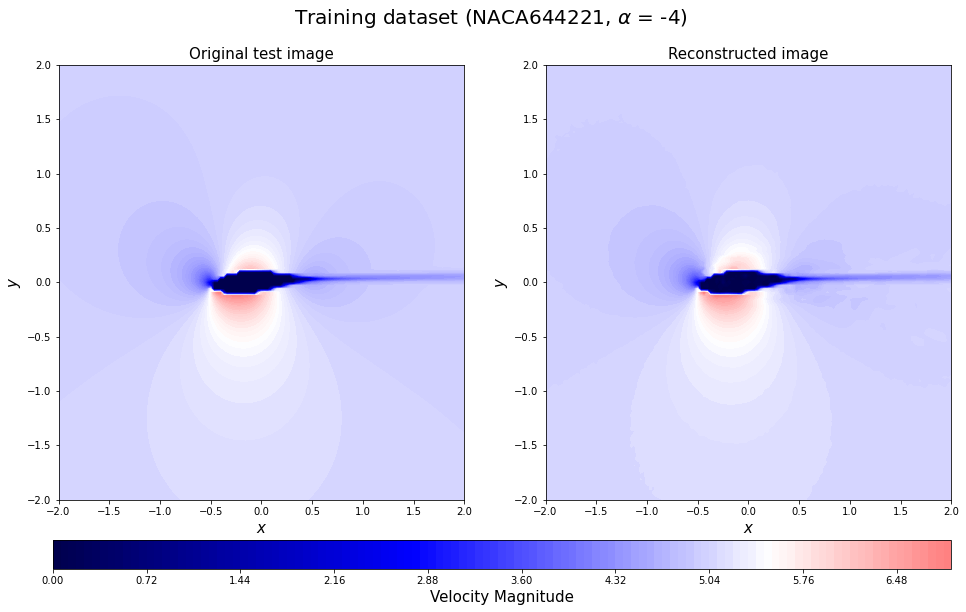

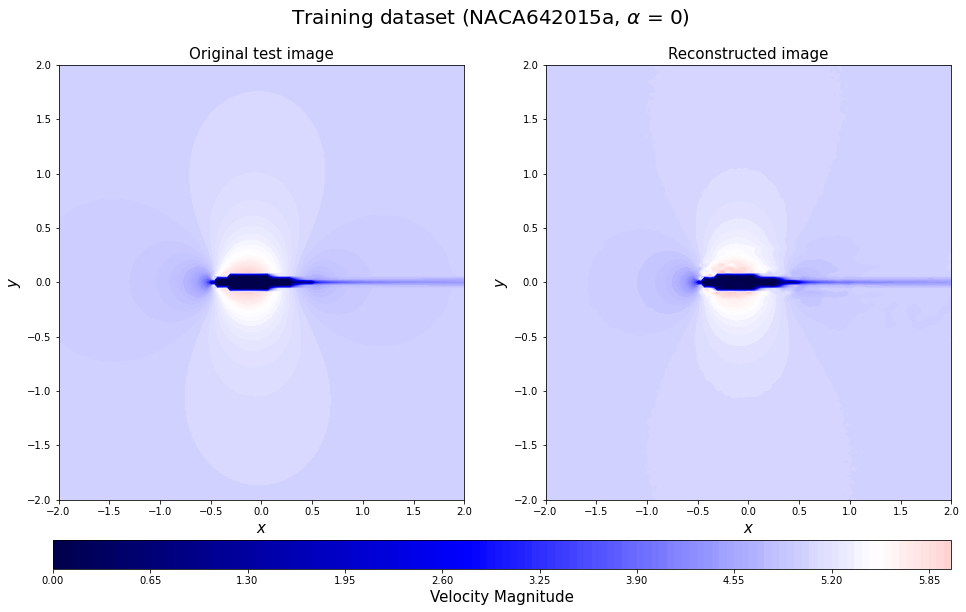

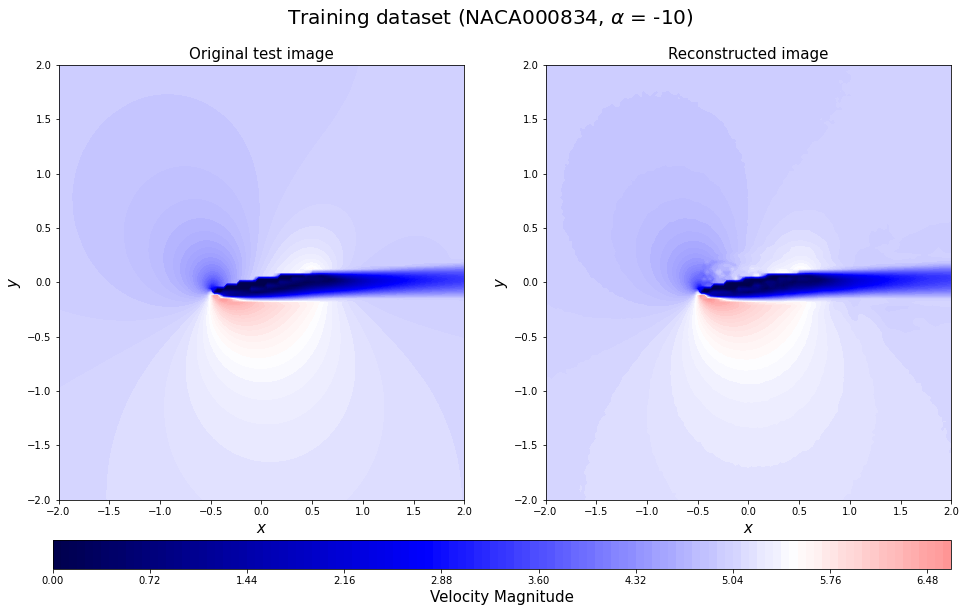

In [64]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_train20_rotate = y_train[20*16+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[20*16+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train20_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[20*16+c])[3:-2], aa_train[20*16+c]),fontsize=20)
    plt.show()

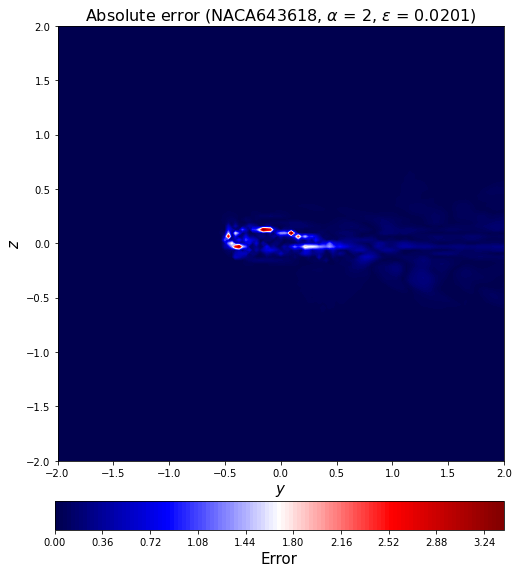

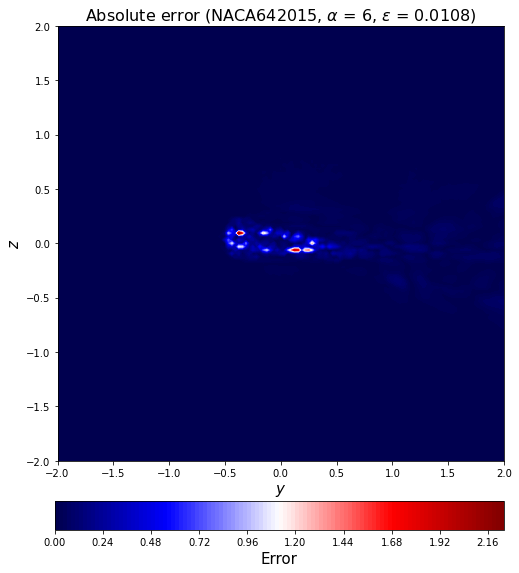

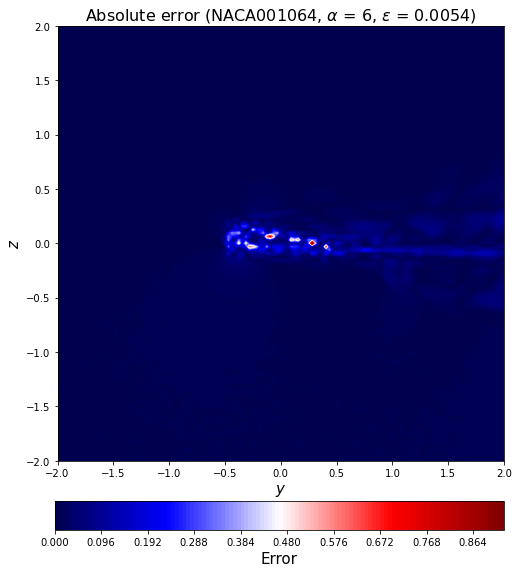

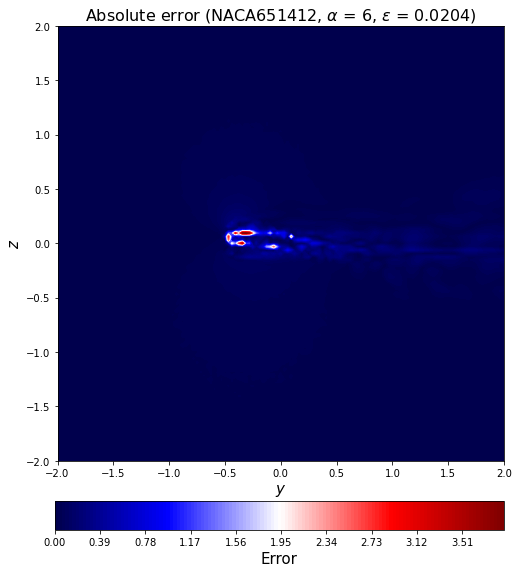

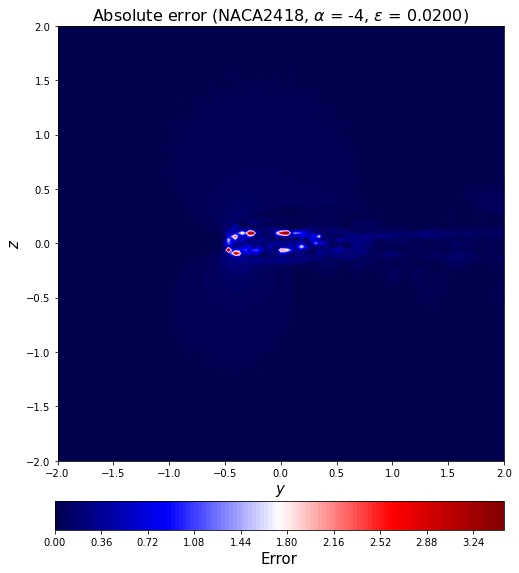

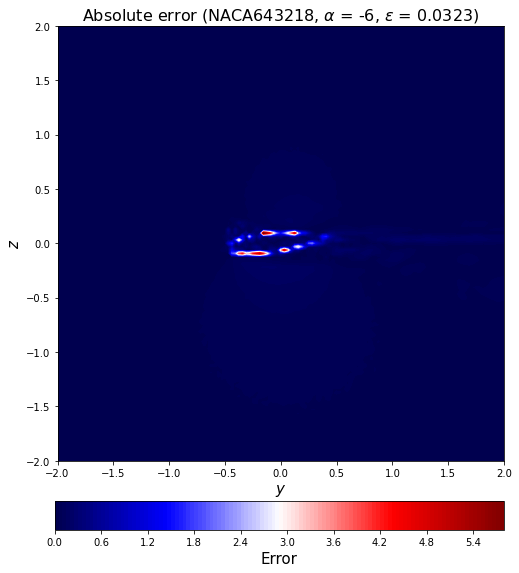

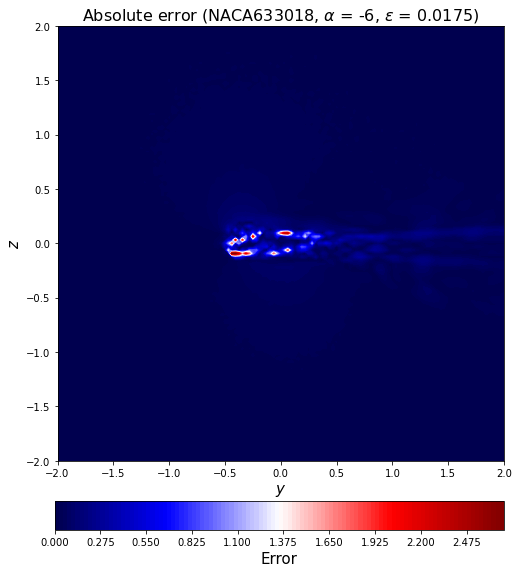

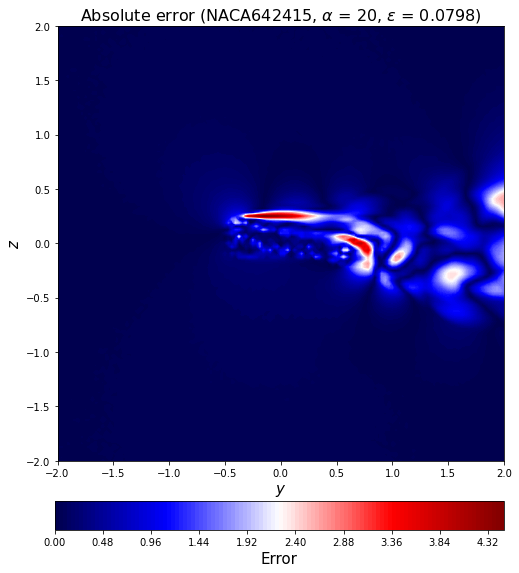

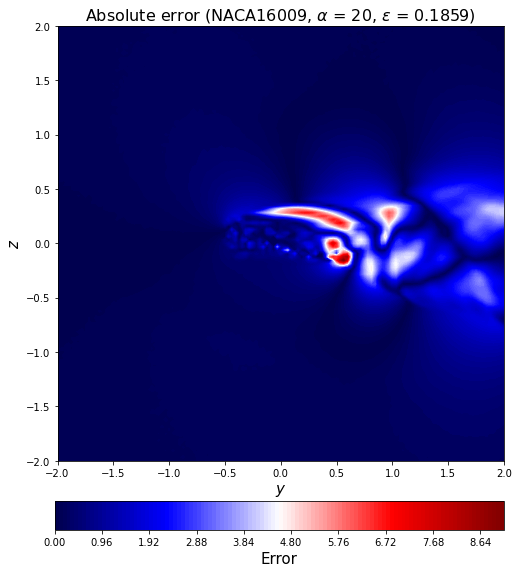

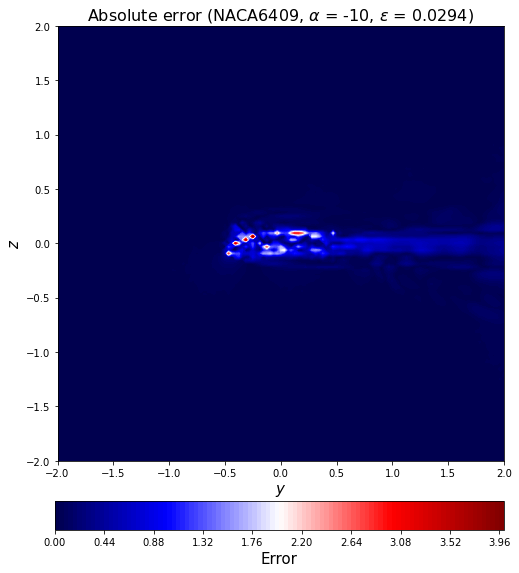

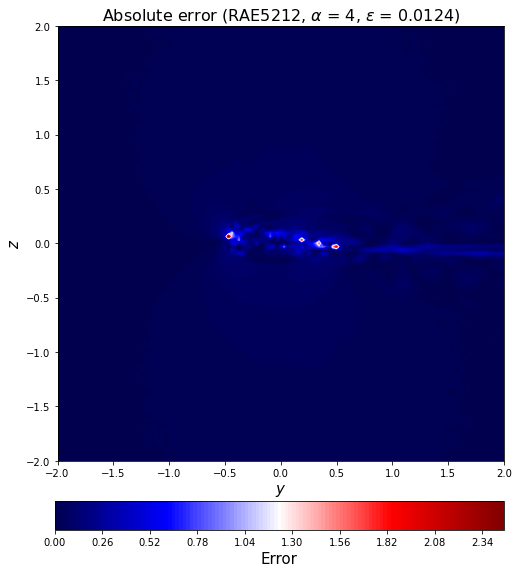

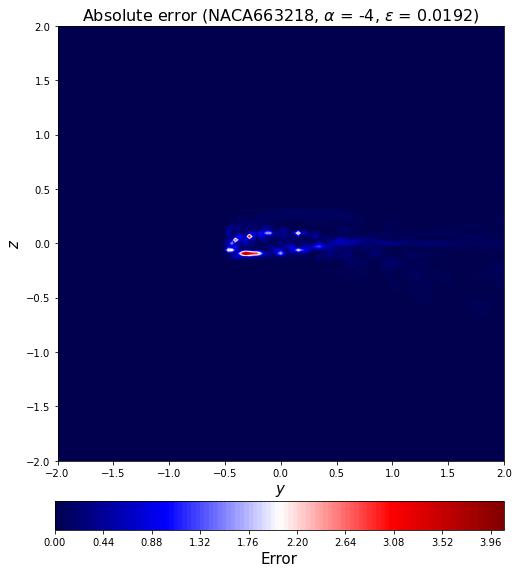

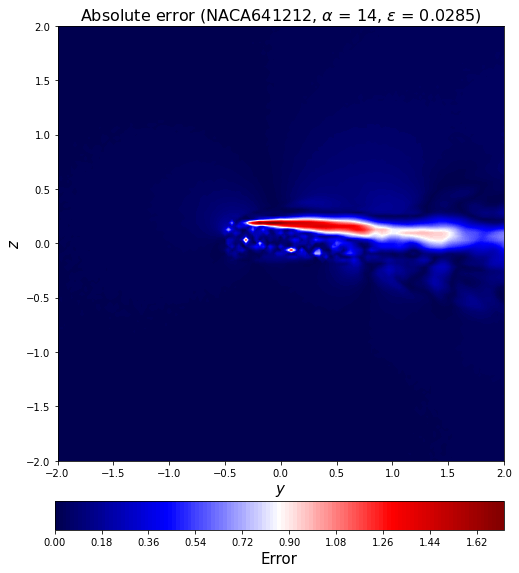

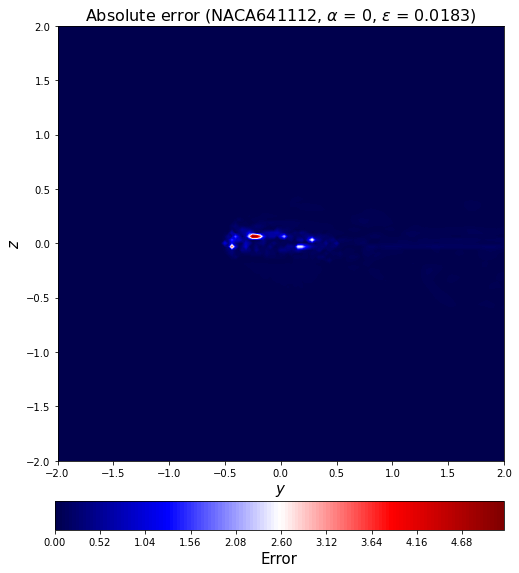

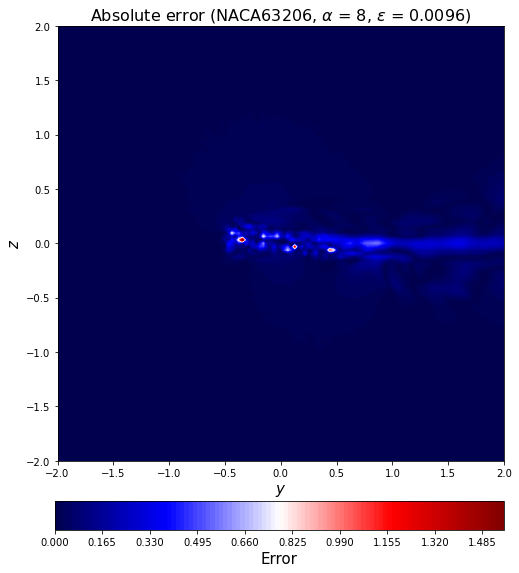

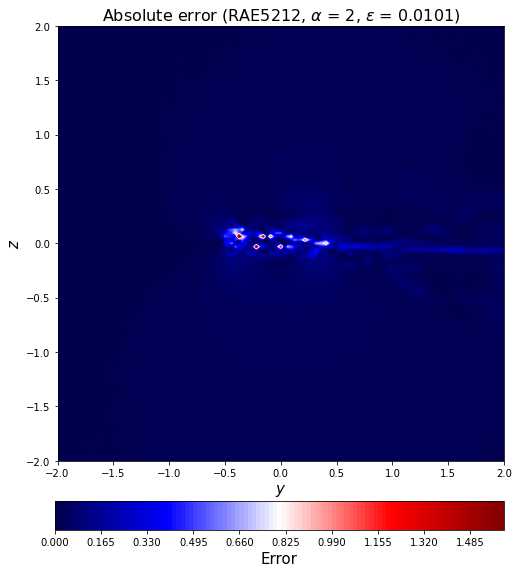

In [65]:
for c in range(0,16):
    error_test_abs2_rotate = error_test_abs[2*16+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[2*16+c])[3:-2],
                                                                       aa_test[2*16+c], l2_error_test_list[2*16+c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

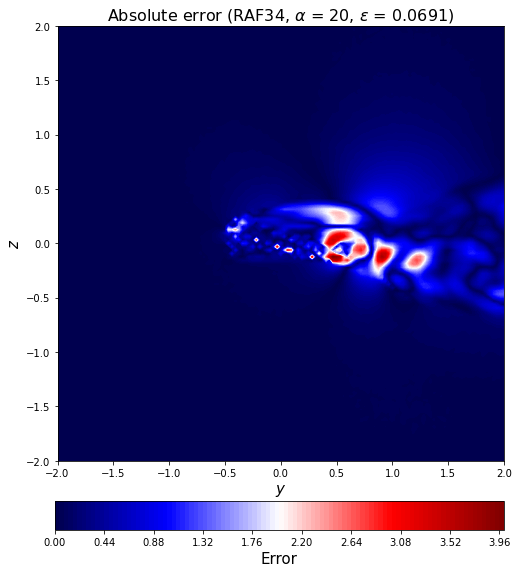

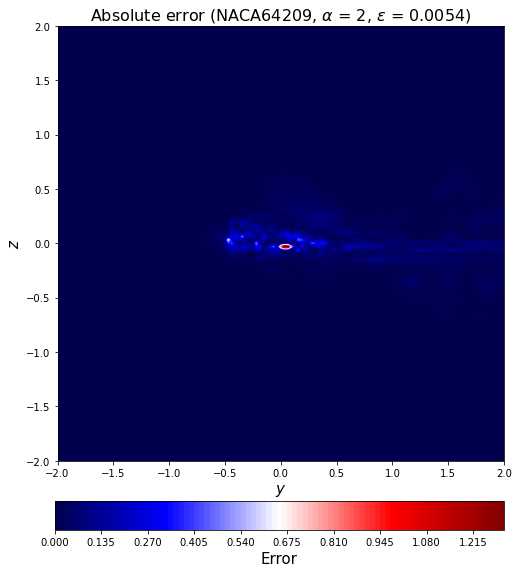

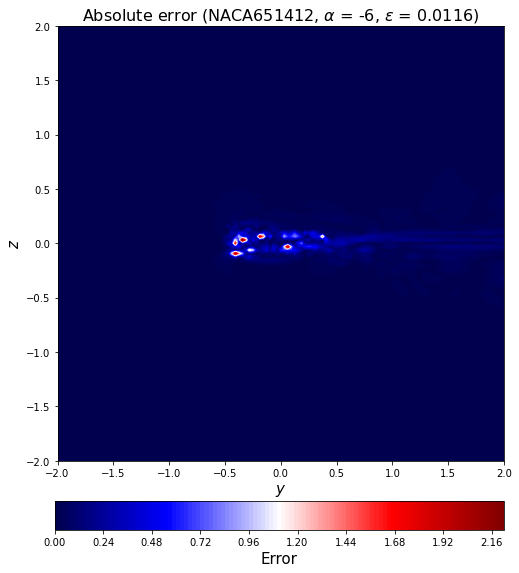

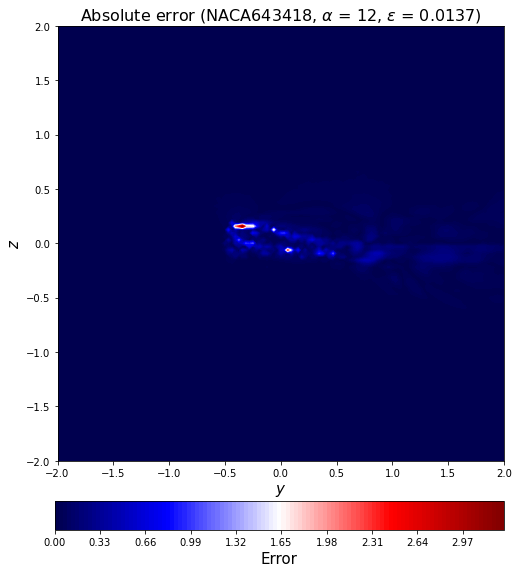

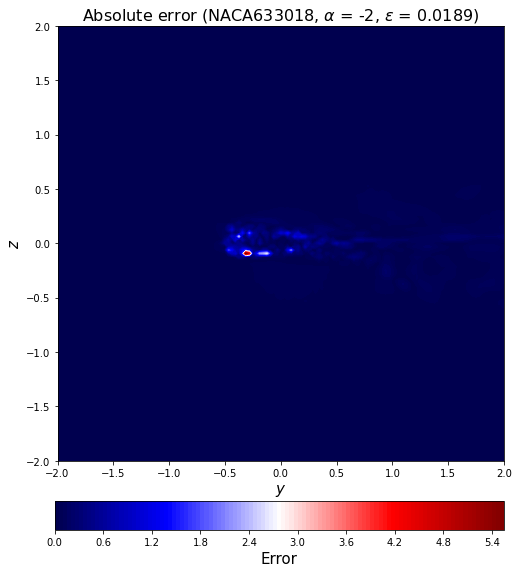

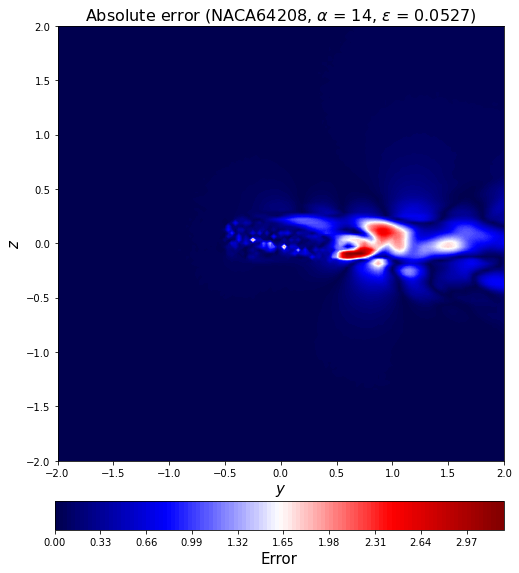

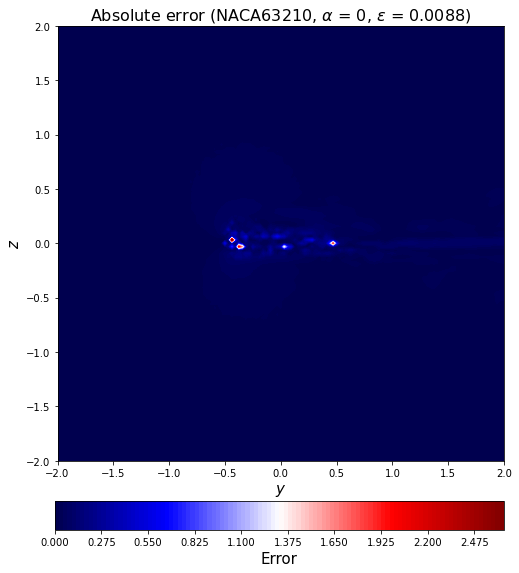

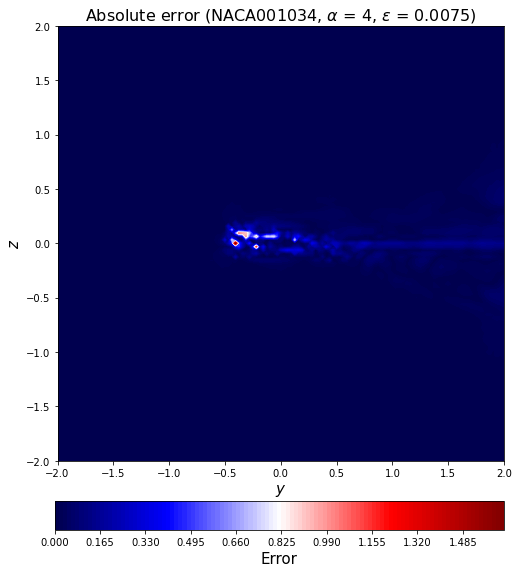

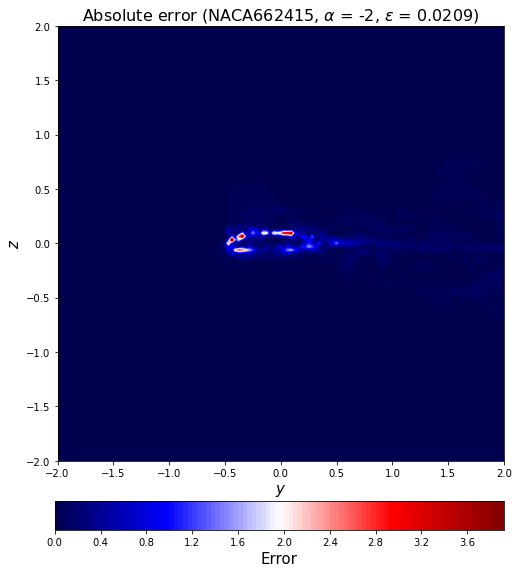

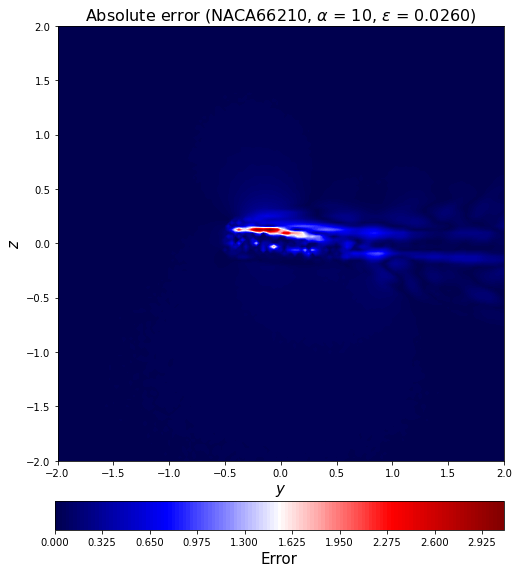

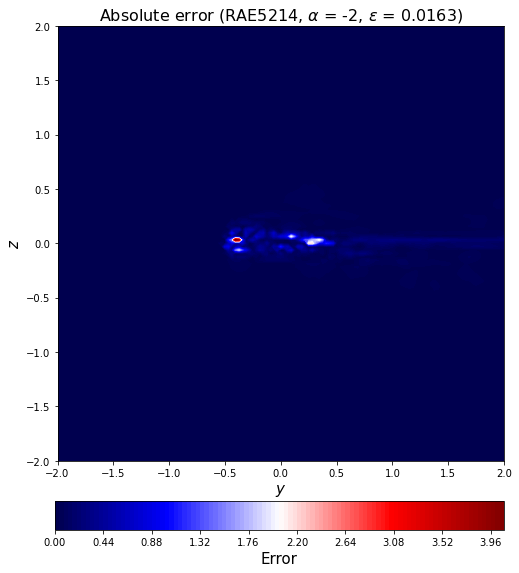

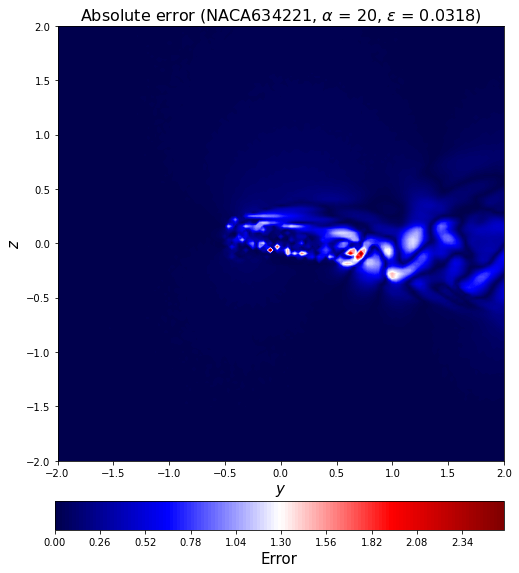

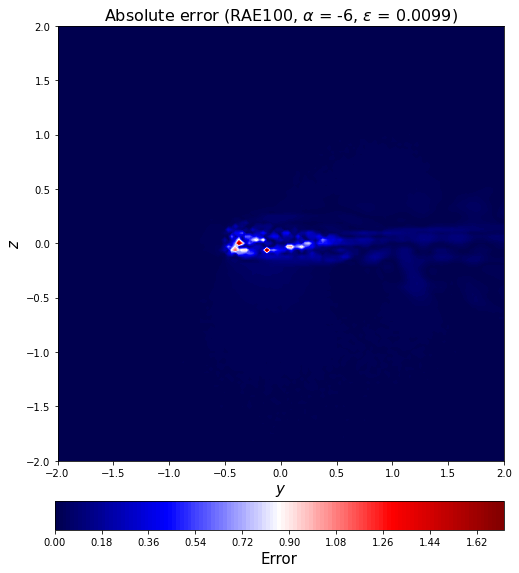

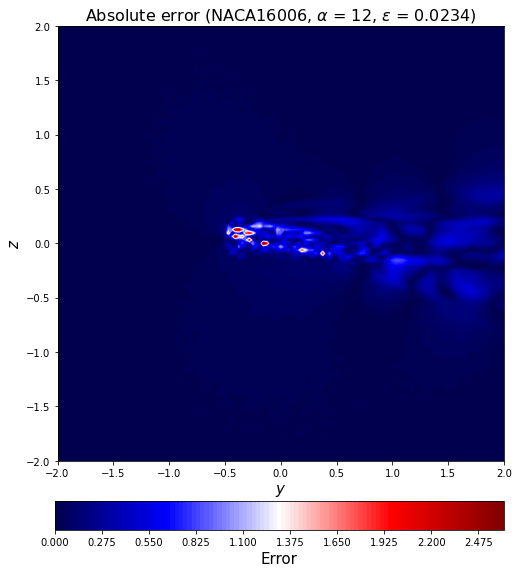

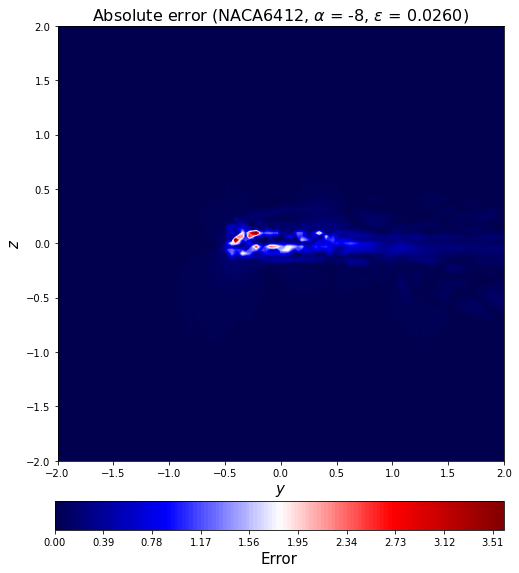

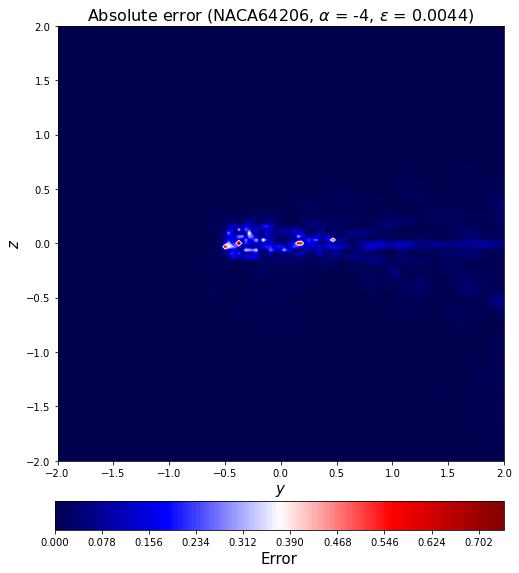

In [66]:
for c in range(0,16):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

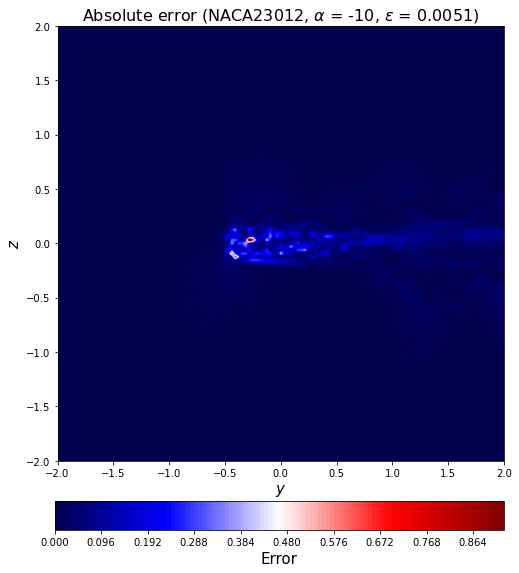

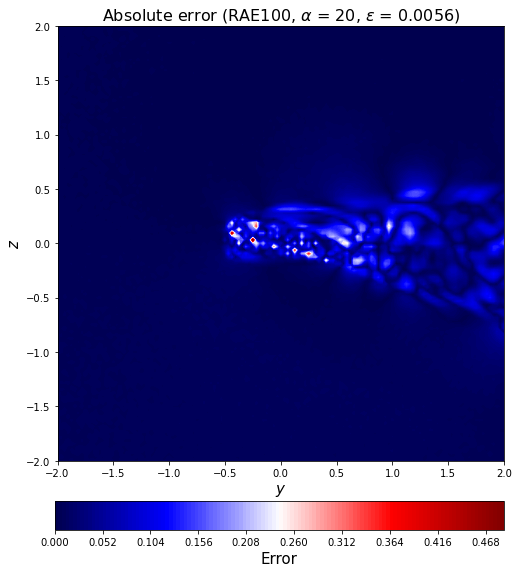

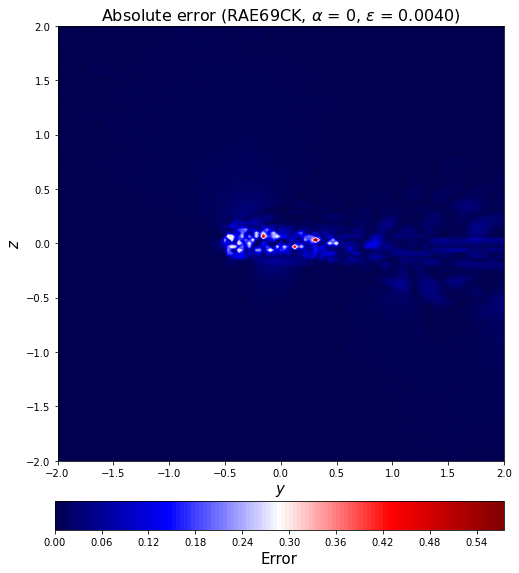

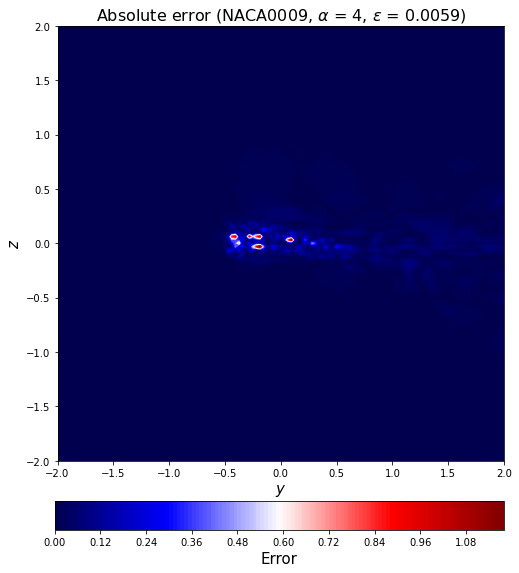

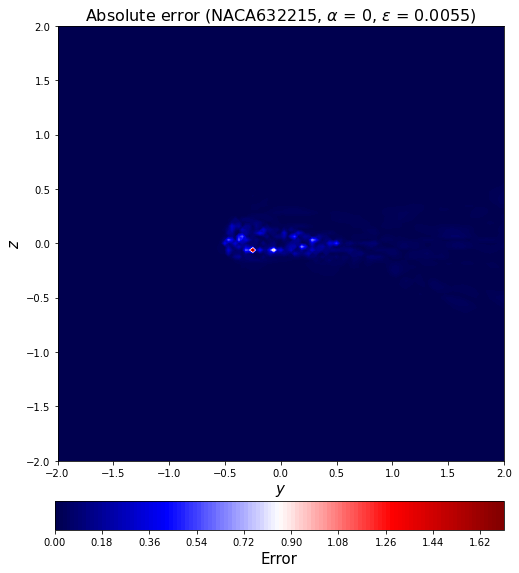

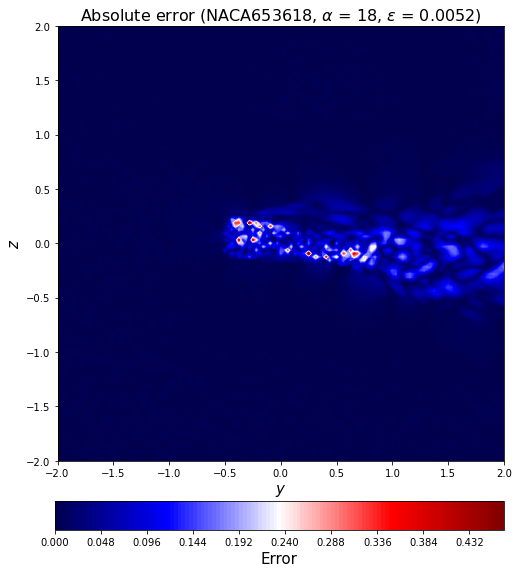

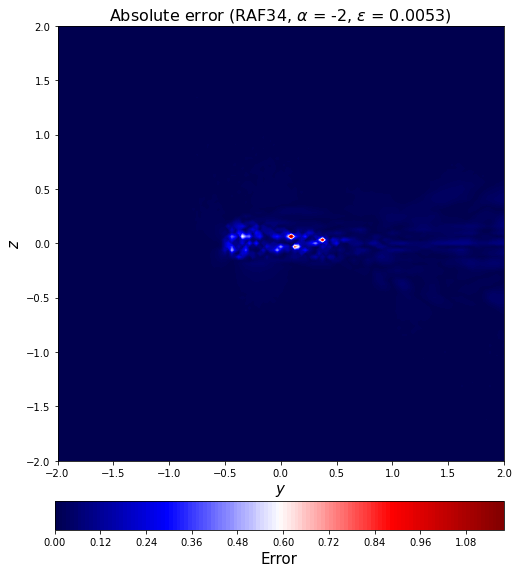

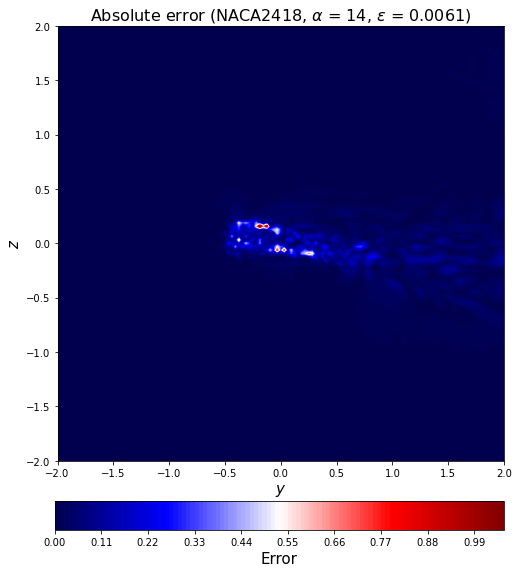

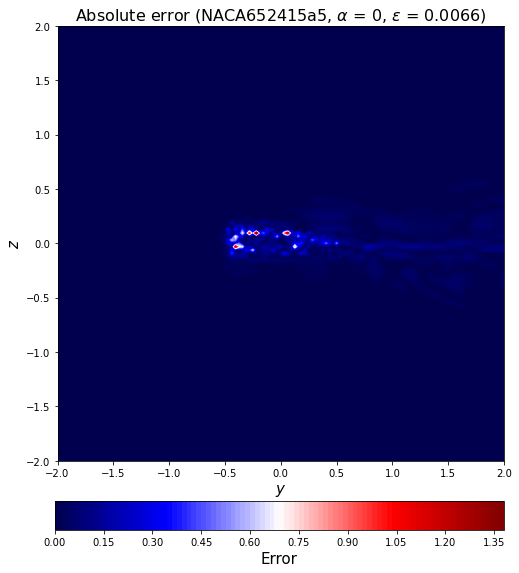

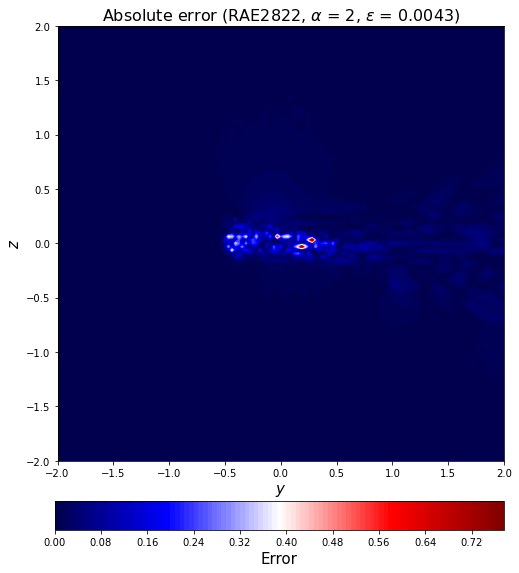

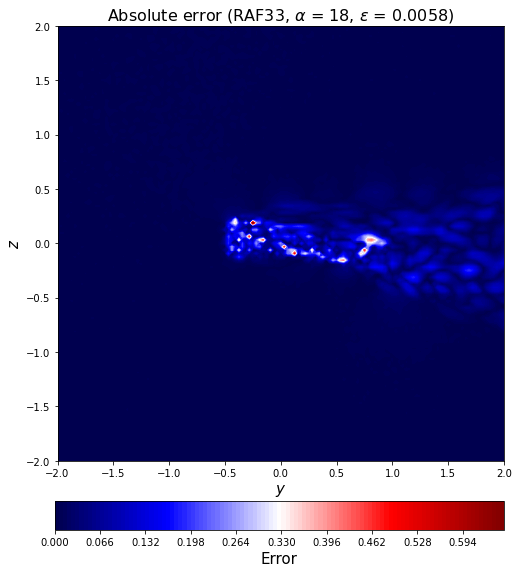

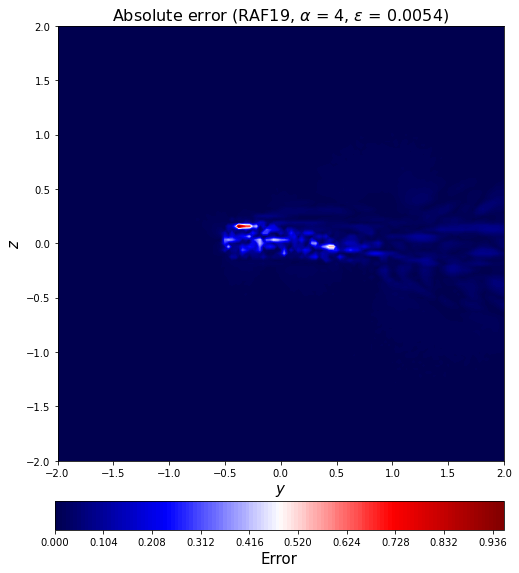

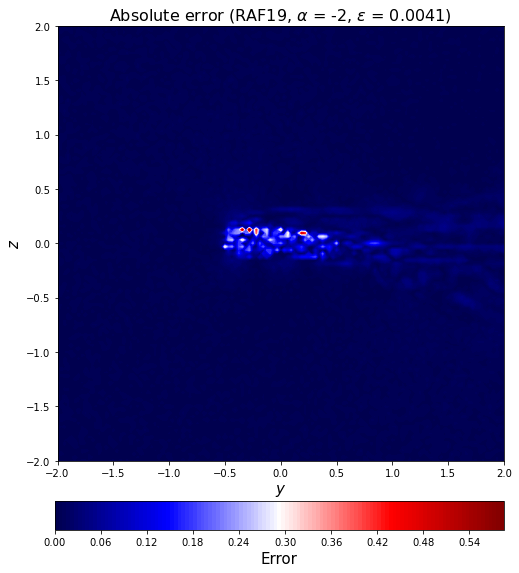

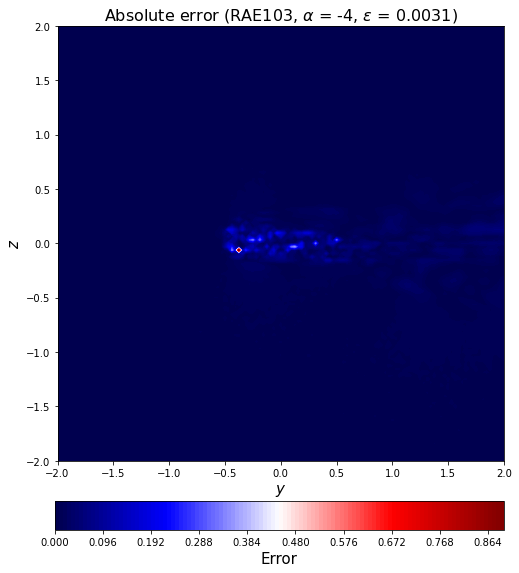

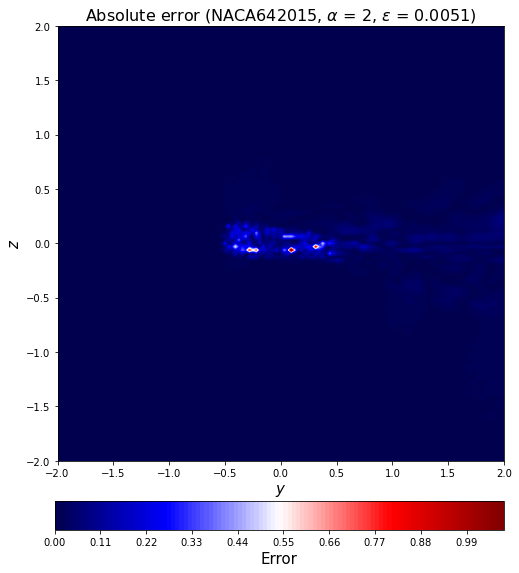

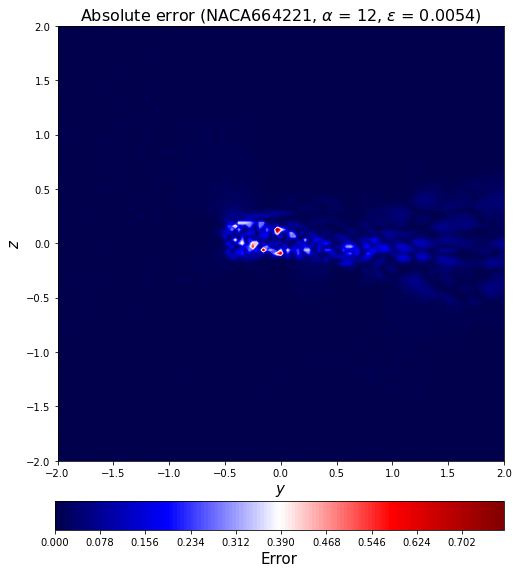

In [67]:
for c in range(0,16):
    error_train_abs2_rotate = error_train_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[c])[3:-2],
                                                                       aa_train[c], l2_error_train_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

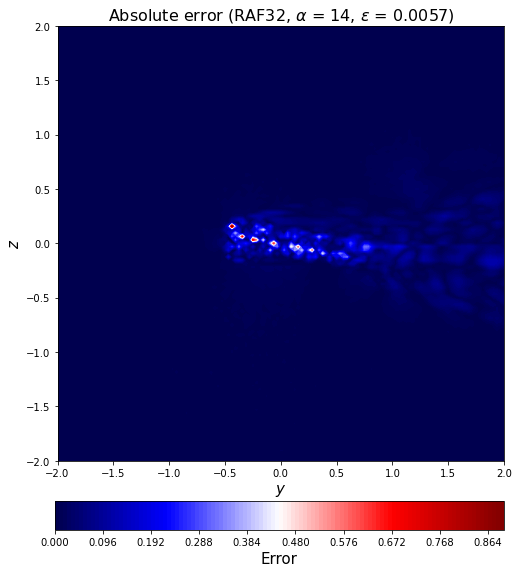

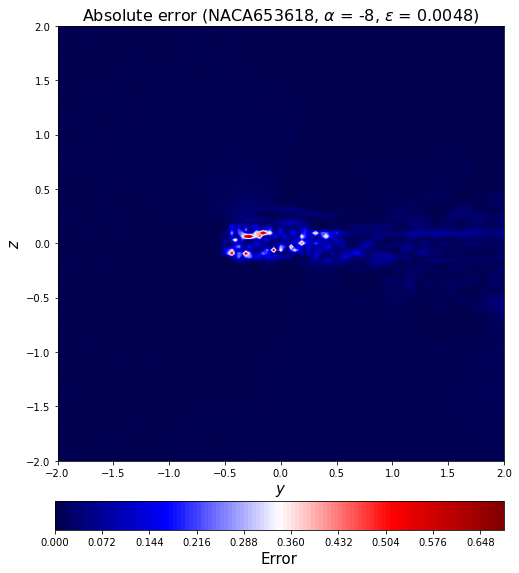

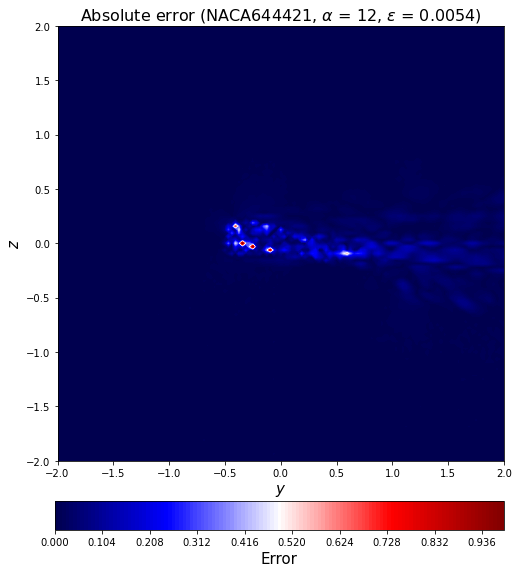

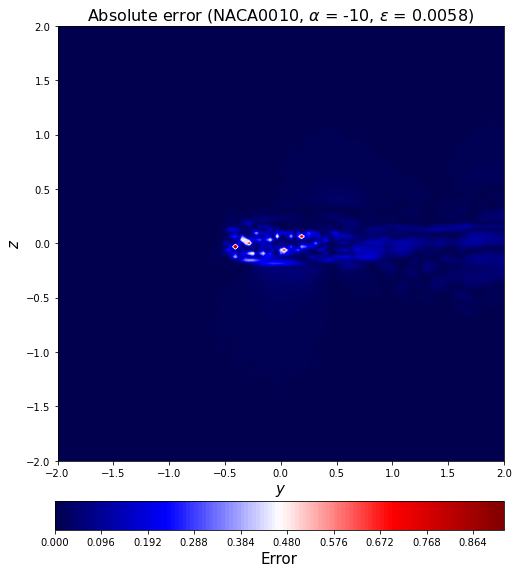

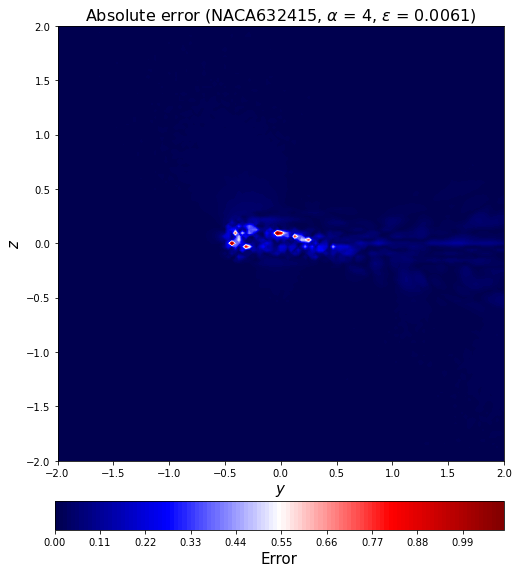

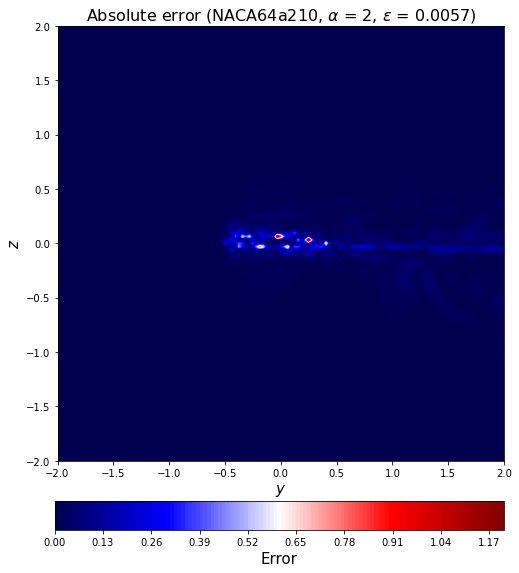

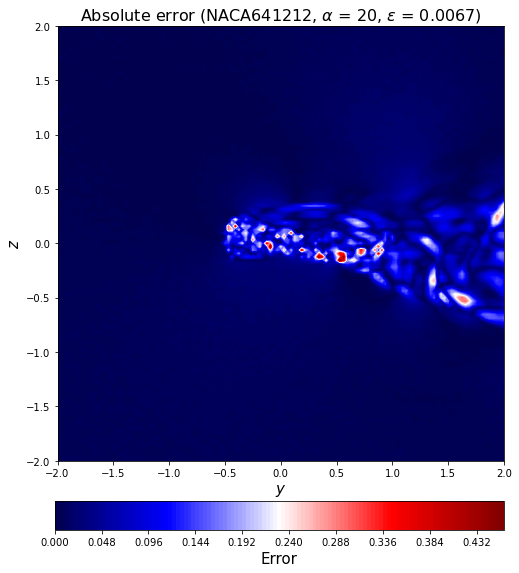

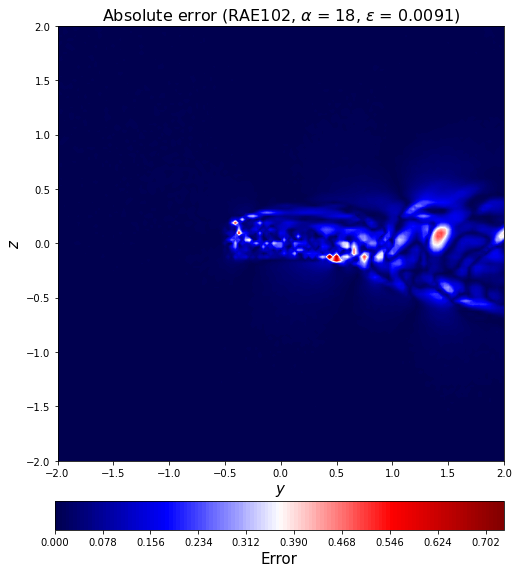

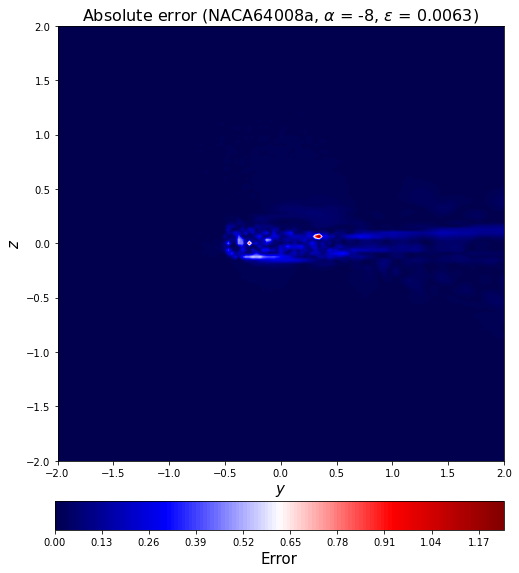

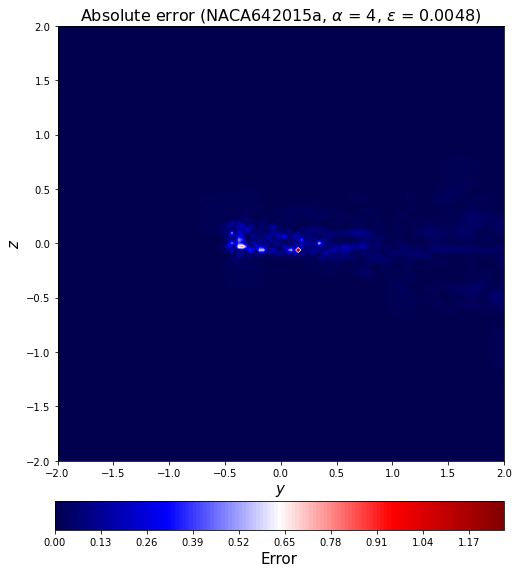

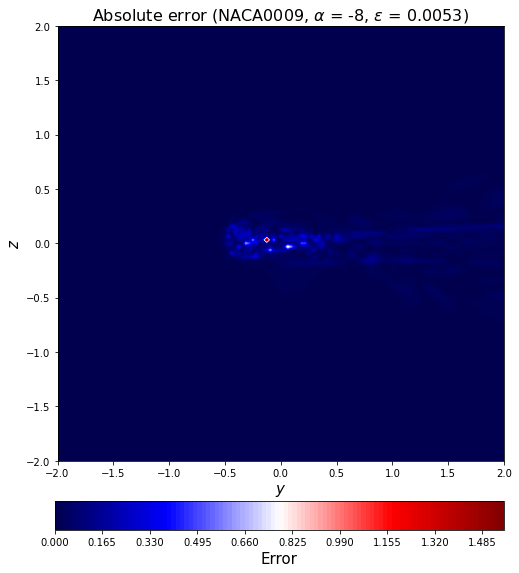

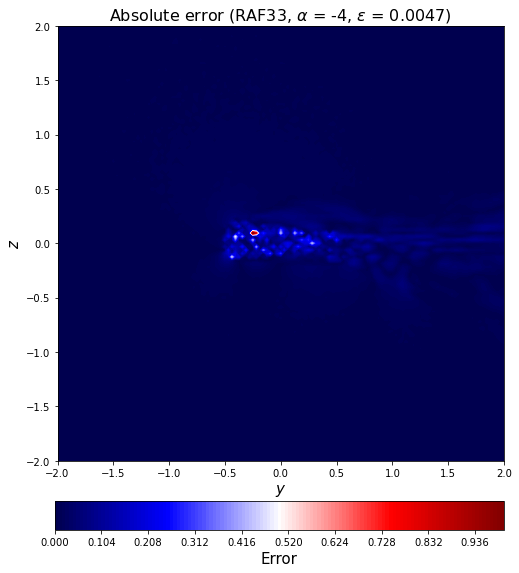

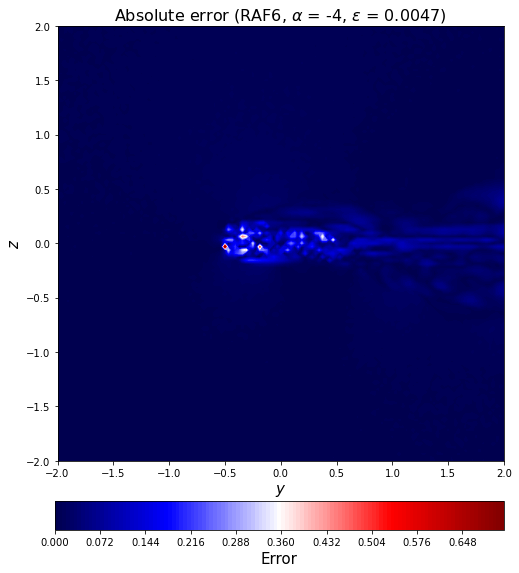

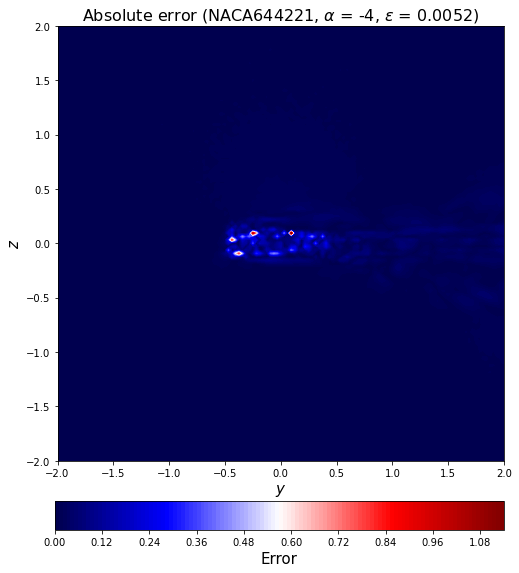

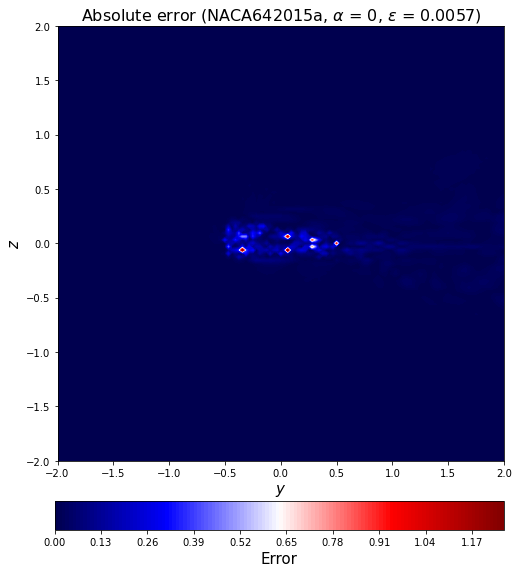

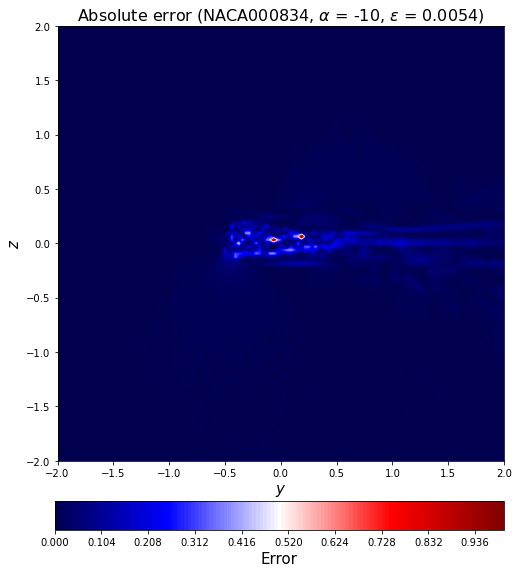

In [68]:
for c in range(0,16):
    error_train_abs2_rotate = error_train_abs[16*20+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[16*20+c])[3:-2],
                                                                       aa_train[16*20+c], l2_error_train_list[16*20+c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()